In [1]:
import pandas as pd
import mplfinance as mpf
import numpy as np
# evaluate a perceptron model on the dataset
from numpy import mean
from numpy import std
from gplearn.genetic import SymbolicRegressor
from sympy import *
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,balanced_accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
from cycler import cycler
import category_encoders as ce
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from IPython.display import Image
import pgmpy
from sklearn.feature_selection import chi2
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
#plots
import plotly.graph_objects as go
import plotly.express as px

#metrics
from sklearn.metrics import roc_curve


In [3]:
#neural network
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split


# <font color= #6B6B6B> 1. Data Description </font>

Description of datasets and info used, info from april 1st 2021 to end of september 2022, ohlc of prices from binance, BTCUSDT.
for trials a dataset from only august is used, frequency is per minute.

- data obtained from https://data.binance.vision/?prefix=data/spot/monthly/klines/BTCUSDT/1m/

In [4]:
#data = pd.read_parquet('ohlcV.parquet')
#data = pd.read_parquet('ohlc-2017.parquet')
data = pd.read_parquet('ohlc-2021.parquet')
#data = pd.read_parquet('ohlc1.parquet')
data = data.drop(['drop', 'close_time'], axis=1)
data.head()

open      high       low     close     volume  \
timestamp                                                                
2021-01-01 00:00:00  28923.63  28961.66  28913.12  28961.66  27.457032   
2021-01-01 00:01:00  28961.67  29017.50  28961.01  29009.91  58.477501   
2021-01-01 00:02:00  29009.54  29016.71  28973.58  28989.30  42.470329   
2021-01-01 00:03:00  28989.68  28999.85  28972.33  28982.69  30.360677   
2021-01-01 00:04:00  28982.67  28995.93  28971.80  28975.65  24.124339   

                     quote_asset_volume  trades  buy_asset_volume  \
timestamp                                                           
2021-01-01 00:00:00        7.943820e+05    1292         16.777195   
2021-01-01 00:01:00        1.695803e+06    1651         33.733818   
2021-01-01 00:02:00        1.231359e+06     986         13.247444   
2021-01-01 00:03:00        8.800168e+05     959          9.456028   
2021-01-01 00:04:00        6.992262e+05     726          6.814644   

                     taker_buy_asset_volume  
timestamp                                    
2021-01-01 00:00:00           485390.826825  
2021-01-01 00:01:00           978176.468202  
2021-01-01 00:02:00           384076.854453  
2021-01-01 00:03:00           274083.075142  
2021-01-01 00:04:00           197519.374888

In [5]:
data.shape

(917727, 9)

In [6]:
data.isnull().sum()

open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
trades                    0
buy_asset_volume          0
taker_buy_asset_volume    0
dtype: int64

In [7]:
#%% Quick description of the data
desc = data.describe()
info = data.info()
print(desc,info)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 917727 entries, 2021-01-01 00:00:00 to 2022-09-30 23:59:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open                    917727 non-null  float64
 1   high                    917727 non-null  float64
 2   low                     917727 non-null  float64
 3   close                   917727 non-null  float64
 4   volume                  917727 non-null  float64
 5   quote_asset_volume      917727 non-null  float64
 6   trades                  917727 non-null  int64  
 7   buy_asset_volume        917727 non-null  float64
 8   taker_buy_asset_volume  917727 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 70.0 MB
                open           high            low          close  \
count  917727.000000  917727.000000  917727.000000  917727.000000   
mean    40625.624820   40653.629847   40597.770063   40625.612126   
std 

<function matplotlib.pyplot.show(close=None, block=None)>

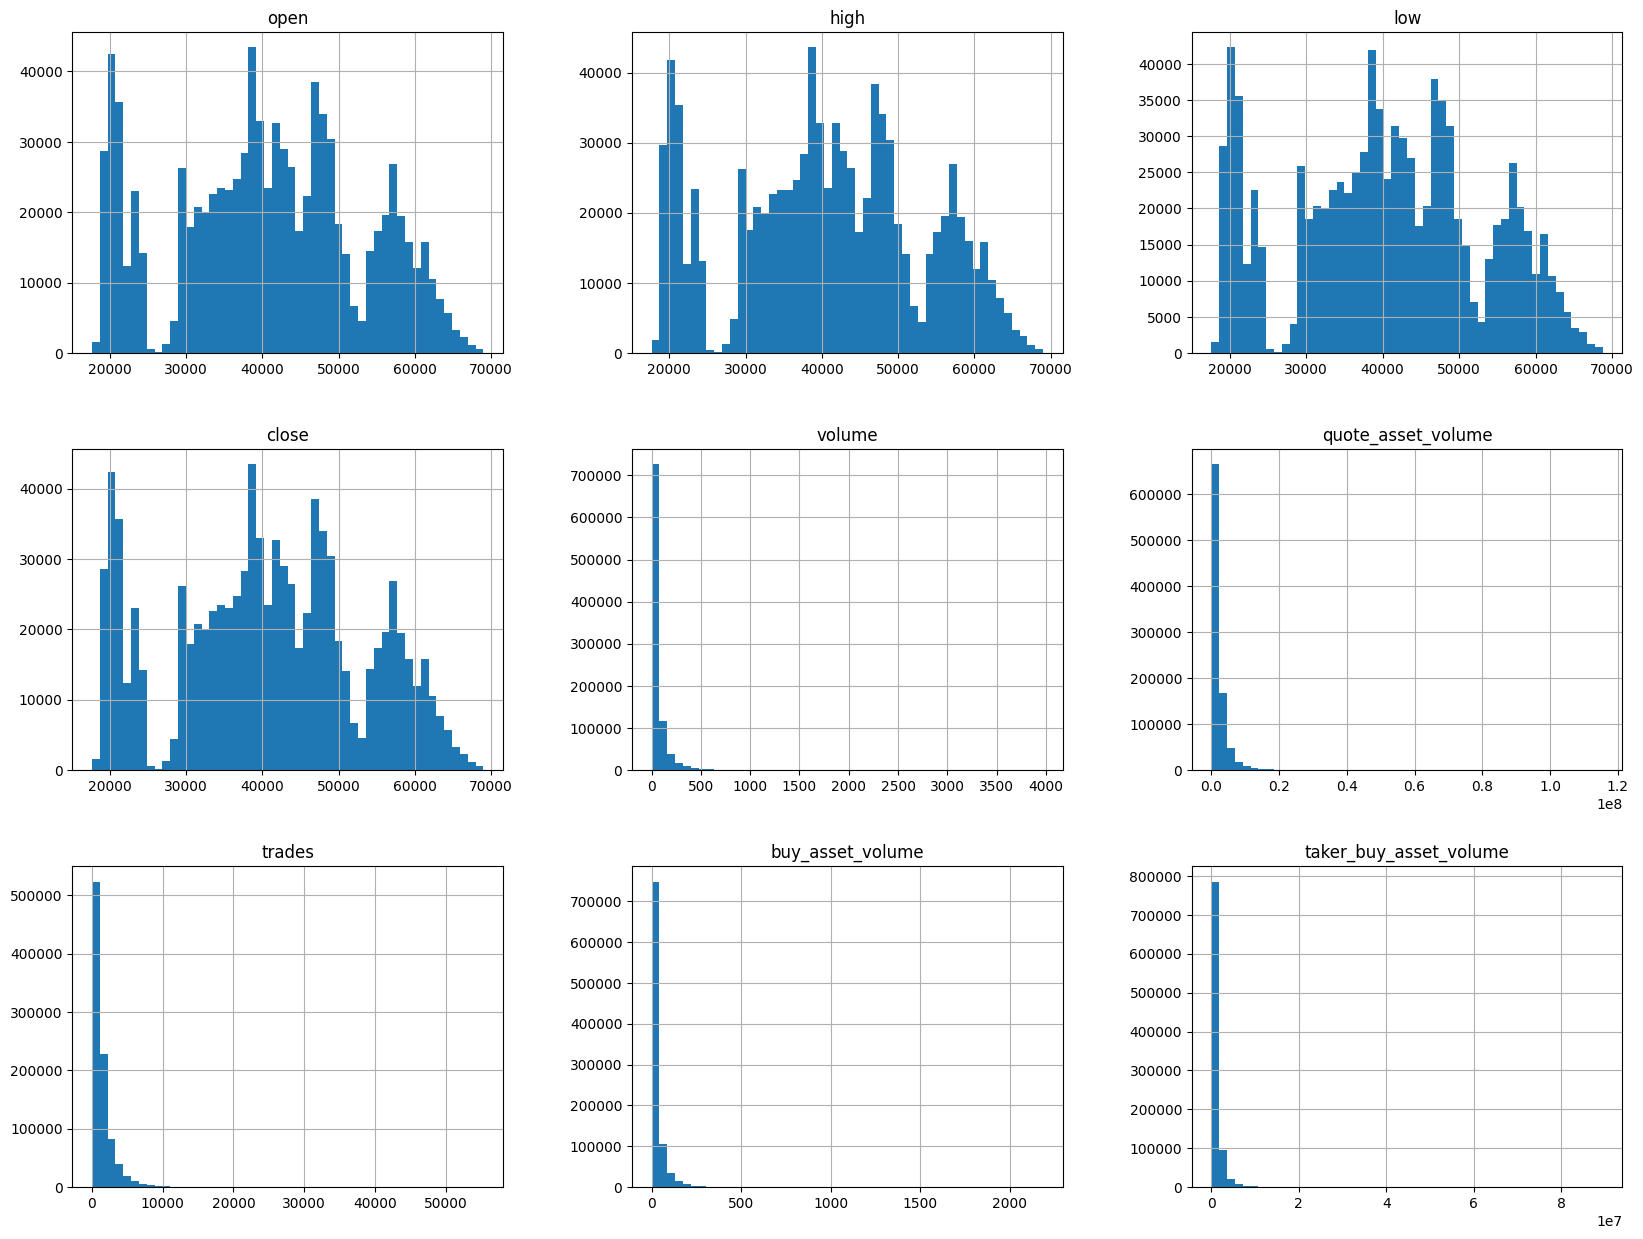

In [8]:
%matplotlib inline
data.hist(bins=50,figsize=(20,15))
plt.show

<AxesSubplot:xlabel='timestamp'>

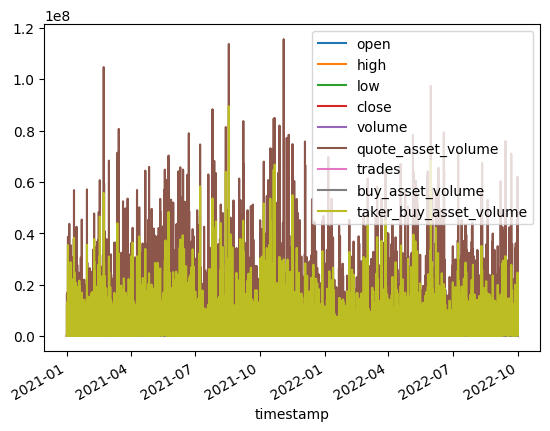

In [9]:
data.plot()

Description of variables:

- Timestamp = time series serving as index, it goes in intervals of 1 minute, from the beggining of 2022, until the end of august.

OHLC variables , this are numeric , based on the prices of the cross between BTC and USDT
- Open is a numeric variable, expressing the first price, at the beginning of the epoch.
- High is a numeric variable, expressing the max value of the epoch.
- Low is the variable expressing the min value of the epoch observed.
- Close is the last value of the epoch.

Volume variables, numeric serve as the total quantity observed on the epoch.

Next we do a resampling, to transform the series from micro time to intra day , the period chosen was 1 hour

In [10]:
rs = '2H'
data1 = data.copy()
data1['open'] = data1['open'].resample(rs).first()
data1['high'] = data1['high'].resample(rs).max()
data1['low'] = data1['low'].resample(rs).min()
data1['close'] = data1['close'].resample(rs).last()
data1['volume'] = data1['volume'].resample(rs).sum()
data1['quote_asset_volume'] = data1['quote_asset_volume'].resample(rs).sum()
data1['trades'] = data1['trades'].resample(rs).sum()
data1['buy_asset_volume'] = data1['buy_asset_volume'].resample(rs).sum()
data1['taker_buy_asset_volume'] = data1['taker_buy_asset_volume'].resample(rs).sum()
data1 =data1.resample(rs).sum()
data1.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 00:00:00  28923.63  29470.00  28690.17  29409.99  7714.879916   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29278.40  3845.576637   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29187.01  3508.003065   
2021-01-01 06:00:00  29187.01  29270.00  28806.54  29092.83  3800.907209   
2021-01-01 08:00:00  29092.84  29307.73  28872.24  29202.21  4030.221761   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 00:00:00        2.251266e+08  162285.0       4375.400939   
2021-01-01 02:00:00        1.126034e+08  100156.0       1979.349172   
2021-01-01 04:00:00        1.024792e+08   97214.0       1683.189576   
2021-01-01 06:00:00        1.104806e+08   99558.0       1753.863667   
2021-01-01 08:00:00        1.172807e+08   98686.0       2230.543748   

                     taker_buy_asset_volume  
timestamp                                    
2021-01-01 00:00:00            1.277175e+08  
2021-01-01 02:00:00            5.795830e+07  
2021-01-01 04:00:00            4.917357e+07  
2021-01-01 06:00:00            5.099678e+07  
2021-01-01 08:00:00            6.493517e+07

In [11]:
data1.shape

(7656, 9)

<AxesSubplot:xlabel='timestamp'>

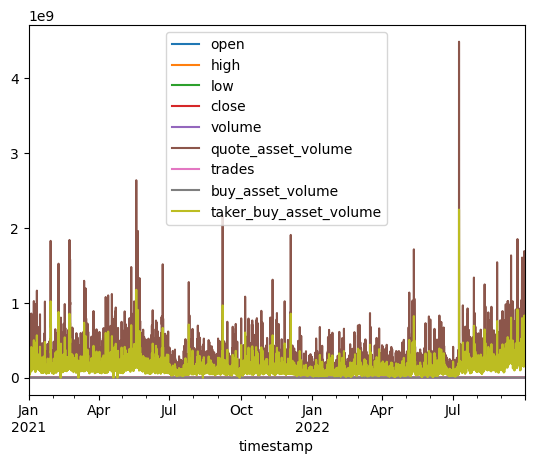

In [12]:
data1.plot()

# <font color= #6B6B6B> 2. Feature Engineering </font>

In [13]:
ohlcv= data1.copy()

In [14]:
# OHLC Chart 
fig = go.Figure(data=go.Ohlc(x=ohlcv.index,
                    open=ohlcv['open'],
                    high=ohlcv['high'],
                    low=ohlcv['low'],
                    close=ohlcv['close']))

fig.show()

#### FEATURES BASIC STATISTICS:
Next we will create the first features based on the OHLCV dataset.
* Volatility(HL):  $ V_t=H_t-L_t$
* High - open(HO): $ HO_t=H_t-O_t$
* Open - low(OL):  $ OL_t=O_t-L_t$
* High - Low(HL):  $ HL_t=H_t-L_t $
* Close - Open(CO): $CO_t=C_t-O_t$


In [15]:
# Volatility
volatility = []
for i in range(len(ohlcv)):
    vol = ohlcv['high'][i] - ohlcv['low'][i]
    volatility.append(vol)
ohlcv['volatility'] = volatility

# micro trends
high_open = []
for i in range(len(ohlcv)):
    ho = ohlcv['high'][i] - ohlcv['open'][i]
    high_open.append(ho)
ohlcv['high_open'] = high_open

open_low = []
for i in range(len(ohlcv)):
    ol = ohlcv['open'][i] - ohlcv['low'][i]
    open_low.append(ol)
ohlcv['open_low'] = open_low

high_low = []  # micro volatility
for i in range(len(ohlcv)):
    hl = ohlcv['high'][i] - ohlcv['low'][i]
    high_low.append(hl)
ohlcv['high_low'] = high_low

close_open = []
for i in range(len(ohlcv)):
    co = ohlcv['close'][i] - ohlcv['open'][i]
    close_open.append(co)
ohlcv['close_open'] = close_open
ohlcv.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 00:00:00  28923.63  29470.00  28690.17  29409.99  7714.879916   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29278.40  3845.576637   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29187.01  3508.003065   
2021-01-01 06:00:00  29187.01  29270.00  28806.54  29092.83  3800.907209   
2021-01-01 08:00:00  29092.84  29307.73  28872.24  29202.21  4030.221761   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 00:00:00        2.251266e+08  162285.0       4375.400939   
2021-01-01 02:00:00        1.126034e+08  100156.0       1979.349172   
2021-01-01 04:00:00        1.024792e+08   97214.0       1683.189576   
2021-01-01 06:00:00        1.104806e+08   99558.0       1753.863667   
2021-01-01 08:00:00        1.172807e+08   98686.0       2230.543748   

                     taker_buy_asset_volume  volatility  high_open  open_low  \
timestamp                                                                      
2021-01-01 00:00:00            1.277175e+08      779.83     546.37    233.46   
2021-01-01 02:00:00            5.795830e+07      345.23      55.26    289.97   
2021-01-01 04:00:00            4.917357e+07      365.60     116.59    249.01   
2021-01-01 06:00:00            5.099678e+07      463.46      82.99    380.47   
2021-01-01 08:00:00            6.493517e+07      435.49     214.89    220.60   

                     high_low  close_open  
timestamp                                  
2021-01-01 00:00:00    779.83      486.36  
2021-01-01 02:00:00    345.23     -131.60  
2021-01-01 04:00:00    365.60      -91.40  
2021-01-01 06:00:00    463.46      -94.18  
2021-01-01 08:00:00    435.49      109.37

In [16]:
ohlcv2 = ohlcv.copy()
ohlcv2.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 00:00:00  28923.63  29470.00  28690.17  29409.99  7714.879916   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29278.40  3845.576637   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29187.01  3508.003065   
2021-01-01 06:00:00  29187.01  29270.00  28806.54  29092.83  3800.907209   
2021-01-01 08:00:00  29092.84  29307.73  28872.24  29202.21  4030.221761   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 00:00:00        2.251266e+08  162285.0       4375.400939   
2021-01-01 02:00:00        1.126034e+08  100156.0       1979.349172   
2021-01-01 04:00:00        1.024792e+08   97214.0       1683.189576   
2021-01-01 06:00:00        1.104806e+08   99558.0       1753.863667   
2021-01-01 08:00:00        1.172807e+08   98686.0       2230.543748   

                     taker_buy_asset_volume  volatility  high_open  open_low  \
timestamp                                                                      
2021-01-01 00:00:00            1.277175e+08      779.83     546.37    233.46   
2021-01-01 02:00:00            5.795830e+07      345.23      55.26    289.97   
2021-01-01 04:00:00            4.917357e+07      365.60     116.59    249.01   
2021-01-01 06:00:00            5.099678e+07      463.46      82.99    380.47   
2021-01-01 08:00:00            6.493517e+07      435.49     214.89    220.60   

                     high_low  close_open  
timestamp                                  
2021-01-01 00:00:00    779.83      486.36  
2021-01-01 02:00:00    345.23     -131.60  
2021-01-01 04:00:00    365.60      -91.40  
2021-01-01 06:00:00    463.46      -94.18  
2021-01-01 08:00:00    435.49      109.37

In [17]:
ohlcv2 = ohlcv2.drop(['quote_asset_volume','buy_asset_volume','taker_buy_asset_volume','trades'],axis = 1)

In [18]:
ohlcv2

open      high       low     close        volume  \
timestamp                                                                   
2021-01-01 00:00:00  28923.63  29470.00  28690.17  29409.99   7714.879916   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29278.40   3845.576637   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29187.01   3508.003065   
2021-01-01 06:00:00  29187.01  29270.00  28806.54  29092.83   3800.907209   
2021-01-01 08:00:00  29092.84  29307.73  28872.24  29202.21   4030.221761   
...                       ...       ...       ...       ...           ...   
2022-09-30 14:00:00  19472.09  20185.00  19436.49  19756.01  85165.671390   
2022-09-30 16:00:00  19756.02  19873.50  19565.52  19679.33  46138.945790   
2022-09-30 18:00:00  19679.33  19838.36  19470.29  19473.52  34869.880080   
2022-09-30 20:00:00  19473.52  19542.72  19284.85  19361.07  27139.951620   
2022-09-30 22:00:00  19359.77  19475.40  19240.44  19422.61  23418.340600   

                     volatility  high_open  open_low  high_low  close_open  
timestamp                                                                   
2021-01-01 00:00:00      779.83     546.37    233.46    779.83      486.36  
2021-01-01 02:00:00      345.23      55.26    289.97    345.23     -131.60  
2021-01-01 04:00:00      365.60     116.59    249.01    365.60      -91.40  
2021-01-01 06:00:00      463.46      82.99    380.47    463.46      -94.18  
2021-01-01 08:00:00      435.49     214.89    220.60    435.49      109.37  
...                         ...        ...       ...       ...         ...  
2022-09-30 14:00:00      748.51     712.91     35.60    748.51      283.92  
2022-09-30 16:00:00      307.98     117.48    190.50    307.98      -76.69  
2022-09-30 18:00:00      368.07     159.03    209.04    368.07     -205.81  
2022-09-30 20:00:00      257.87      69.20    188.67    257.87     -112.45  
2022-09-30 22:00:00      234.96     115.63    119.33    234.96       62.84  

[7656 rows x 10 columns]

In [19]:
symbolic_params = {'functions': ["sub", "add", 'inv', 'mul', 'div', 'abs', 'log'],
        'population': 5000, 'tournament':20, 'hof': 20, 'generations': 5, 'n_features':20,
        'init_depth': (4,8), 'init_method': 'half and half', 'parsimony': 0.1, 'constants': None,
        'metric': 'pearson', 'metric_goal': 0.65, 
        'prob_cross': 0.4, 'prob_mutation_subtree': 0.3,
        'prob_mutation_hoist': 0.1, 'prob_mutation_point': 0.2,
        'verbose': True, 'random_cv': None, 'parallelization': True, 'warm_start': True }

Next we will create autoregressive features which are new features that take into account the effect of past values on current values

In [20]:
def autoregressive_features(p_data, p_memory):
    """
    Creacion de variables de naturaleza autoregresiva (resagos, promedios, diferencias)
    Parameters
    ----------
    p_data: pd.DataFrame
        with OHLCV columns: Open, High, Low, Close, Volume
    p_memory: int
        A value that represents the implicit assumption of a "memory" effect in the prices
    Returns
    -------
    r_features: pd.DataFrame
        
    """

    # work with a separate copy of original data
    data = ohlcv2.copy()

    # nth-period final price "movement"
    data['co'] = (data['close'] - data['open'])
    # nth-period uptrend movement
    data['ho'] = (data['high'] - data['open'])
    # nth-period downtrend movement
    data['ol'] = (data['open'] - data['low'])
    # nth-period volatility measure
    data['hl'] = (data['high'] - data['low'])

    # N features with window-based calculations
    for n in range(0, p_memory):

        data['ma_ol'] = data['ol'].rolling(n + 2).mean()
        data['ma_ho'] = data['ho'].rolling(n + 2).mean()
        data['ma_hl'] = data['hl'].rolling(n + 2).mean()
        
        data['lag_ol_' + str(n + 1)] = data['ol'].shift(n + 1)
        data['lag_ho_' + str(n + 1)] = data['ho'].shift(n + 1)
        data['lag_hl_' + str(n + 1)] = data['hl'].shift(n + 1)

        data['sd_ol_' + str(n + 1)] = data['ol'].rolling(n + 1).std()
        data['sd_ho_' + str(n + 1)] = data['ho'].rolling(n + 1).std()
        data['sd_hl_' + str(n + 1)] = data['hl'].rolling(n + 1).std()

        data['lag_vol_' + str(n + 1)] = data['volume'].shift(n + 1)
        data['sum_vol_' + str(n + 1)] = data['volume'].rolling(n + 1).sum()
        data['mean_vol_' + str(n + 1)] = data['volume'].rolling(n + 1).mean()

    # timestamp as index
    data.index = pd.to_datetime(data.index)
    # select columns, drop for NAs, change column types, reset index
    r_features = data.drop(['open', 'high', 'low', 'close', 'hl', 'ol', 'ho', 'volume'], axis=1)
    r_features = r_features.dropna(axis='columns', how='all')
    #r_features = r_features.dropna(axis='rows')
    r_features.iloc[:, 1:] = r_features.iloc[:, 1:].astype(float)
    r_features.reset_index(inplace=True, drop=True)

    return r_features

In [21]:
def symbolic_features(p_x, p_y, p_params):
    """
    Feature engineering process with symbolic variables by using genetic programming. 
    Parameters
    ----------
    p_x: pd.DataFrame / np.array / list
        with regressors or predictor variables
        p_x = data_features.iloc[:, 1:]
    p_y: pd.DataFrame / np.array / list
        with variable to predict
        p_y = data_features.iloc[:, 0]
    p_params: dict
        with parameters for the genetic programming function
        p_params = {'functions': ["sub", "add", 'inv', 'mul', 'div', 'abs', 'log'],
        'population': 5000, 'tournament':20, 'hof': 20, 'generations': 5, 'n_features':20,
        'init_depth': (4,8), 'init_method': 'half and half', 'parsimony': 0.1, 'constants': None,
        'metric': 'pearson', 'metric_goal': 0.65, 
        'prob_cross': 0.4, 'prob_mutation_subtree': 0.3,
        'prob_mutation_hoist': 0.1. 'prob_mutation_point': 0.2,
        'verbose': True, 'random_cv': None, 'parallelization': True, 'warm_start': True }
    Returns
    -------
    results: dict
        With response information
        {'fit': model fitted, 'params': model parameters, 'model': model,
         'data': generated data with variables, 'best_programs': models best programs}
    References
    ----------
    https://gplearn.readthedocs.io/en/stable/reference.html#gplearn.genetic.SymbolicTransformer
    
    
    **** NOTE ****
    simplified internal calculation for correlation (asuming w=1)
    
    y_pred_demean = y_pred - np.average(y_pred)
    y_demean = y - np.average(y)
                              np.sum(y_pred_demean * y_demean)
    pearson =  ---------------------------------------------------------------
                np.sqrt((np.sum(y_pred_demean ** 2) * np.sum(y_demean ** 2)))  
    """
     
    # Function to produce Symbolic Features
    model = SymbolicTransformer(function_set=p_params['functions'], population_size=p_params['population'],
                                tournament_size=p_params['tournament'], hall_of_fame=p_params['hof'],
                                generations=p_params['generations'], n_components=p_params['n_features'],

                                init_depth=p_params['init_depth'], init_method=p_params['init_method'],
                                parsimony_coefficient=p_params['parsimony'],
                                const_range=p_params['constants'],
                                
                                metric=p_params['metric'], stopping_criteria=p_params['metric_goal'],

                                p_crossover=p_params['prob_cross'],
                                p_subtree_mutation=p_params['prob_mutation_subtree'],
                                p_hoist_mutation=p_params['prob_mutation_hoist'],
                                p_point_mutation=p_params['prob_mutation_point'],
                                max_samples=1,

                                verbose=p_params['verbose'], warm_start=p_params['warm_start'],
                                random_state=123, n_jobs=-1 if p_params['parallelization'] else 1,
                                feature_names=p_x.columns)

    # SymbolicTransformer fit
    model_fit = model.fit_transform(p_x, p_y)

    # output data of the model
    data = pd.DataFrame(model_fit)

    # parameters of the model
    model_params = model.get_params()

    # best programs dataframe
    best_programs = {}
    for p in model._best_programs:
        factor_name = 'sym' + str(model._best_programs.index(p))
        best_programs[factor_name] = {'raw_fitness': p.raw_fitness_, 'reg_fitness': p.fitness_, 
                                      'expression': str(p), 'depth': p.depth_, 'length': p.length_}

    # format and sorting
    best_programs = pd.DataFrame(best_programs).T
    best_programs = best_programs.sort_values(by='raw_fitness', ascending=False)

    # results
    results = {'fit': model_fit, 'params': model_params, 'model': model, 'data': data,
               'best_programs': best_programs, 'details': model.run_details_}

    return results


In [22]:
p_memory = 10
data_ar = autoregressive_features(p_data=ohlcv2, p_memory=p_memory)
data_ar.index = ohlcv2.index
data_ar

volatility  high_open  open_low  high_low  close_open  \
timestamp                                                                    
2021-01-01 00:00:00      779.83     546.37    233.46    779.83      486.36   
2021-01-01 02:00:00      345.23      55.26    289.97    345.23     -131.60   
2021-01-01 04:00:00      365.60     116.59    249.01    365.60      -91.40   
2021-01-01 06:00:00      463.46      82.99    380.47    463.46      -94.18   
2021-01-01 08:00:00      435.49     214.89    220.60    435.49      109.37   
...                         ...        ...       ...       ...         ...   
2022-09-30 14:00:00      748.51     712.91     35.60    748.51      283.92   
2022-09-30 16:00:00      307.98     117.48    190.50    307.98      -76.69   
2022-09-30 18:00:00      368.07     159.03    209.04    368.07     -205.81   
2022-09-30 20:00:00      257.87      69.20    188.67    257.87     -112.45   
2022-09-30 22:00:00      234.96     115.63    119.33    234.96       62.84   

                         co       ma_ol       ma_ho       ma_hl  lag_ol_1  \
timestamp                                                                   
2021-01-01 00:00:00  486.36         NaN         NaN         NaN       NaN   
2021-01-01 02:00:00 -131.60         NaN         NaN         NaN    233.46   
2021-01-01 04:00:00  -91.40         NaN         NaN         NaN    289.97   
2021-01-01 06:00:00  -94.18         NaN         NaN         NaN    249.01   
2021-01-01 08:00:00  109.37         NaN         NaN         NaN    380.47   
...                     ...         ...         ...         ...       ...   
2022-09-30 14:00:00  283.92  102.136364  166.945455  269.081818    280.43   
2022-09-30 16:00:00  -76.69  106.181818  157.220000  263.401818     35.60   
2022-09-30 18:00:00 -205.81  123.104545  159.124545  282.229091    190.50   
2022-09-30 20:00:00 -112.45  139.025455  148.271818  287.297273    209.04   
2022-09-30 22:00:00   62.84  135.392727  148.832727  284.225455    188.67   

                     ...    mean_vol_9  lag_ol_10  lag_ho_10  lag_hl_10  \
timestamp            ...                                                  
2021-01-01 00:00:00  ...           NaN        NaN        NaN        NaN   
2021-01-01 02:00:00  ...           NaN        NaN        NaN        NaN   
2021-01-01 04:00:00  ...           NaN        NaN        NaN        NaN   
2021-01-01 06:00:00  ...           NaN        NaN        NaN        NaN   
2021-01-01 08:00:00  ...           NaN        NaN        NaN        NaN   
...                  ...           ...        ...        ...        ...   
2022-09-30 14:00:00  ...  37509.359012     146.00     224.46     370.46   
2022-09-30 16:00:00  ...  39877.197900      22.89     138.08     160.97   
2022-09-30 18:00:00  ...  39658.637812      13.54     188.58     202.12   
2022-09-30 20:00:00  ...  39594.742534     159.29     109.46     268.75   
2022-09-30 22:00:00  ...  40236.646567     196.11       2.59     198.70   

                      sd_ol_10    sd_ho_10    sd_hl_10   lag_vol_10  \
timestamp                                                             
2021-01-01 00:00:00        NaN         NaN         NaN          NaN   
2021-01-01 02:00:00        NaN         NaN         NaN          NaN   
2021-01-01 04:00:00        NaN         NaN         NaN          NaN   
2021-01-01 06:00:00        NaN         NaN         NaN          NaN   
2021-01-01 08:00:00        NaN         NaN         NaN          NaN   
...                        ...         ...         ...          ...   
2022-09-30 14:00:00  90.917998  203.448167  185.410577  36821.64283   
2022-09-30 16:00:00  91.033555  203.812177  182.585800  15038.30415   
2022-09-30 18:00:00  87.877779  203.551865  182.903886  24828.39580   
2022-09-30 20:00:00  89.294680  204.971773  183.078199  36836.92087   
2022-09-30 22:00:00  86.916579  198.832113  181.439422  27715.00912   

                       sum_vol_10   mean_vol_10  
timestamp                                        
2021

In [23]:
ohlcv = pd.merge(ohlcv, data_ar,on='timestamp')
ohlcv = ohlcv.dropna(axis='rows')

ohlcv

open      high       low     close        volume  \
timestamp                                                                   
2021-01-01 20:00:00  29029.04  29289.82  28880.37  29160.39   3285.778723   
2021-01-01 22:00:00  29163.17  29338.89  29104.57  29331.69   2098.159282   
2021-01-02 00:00:00  29331.70  29400.00  28946.53  29359.47   4530.156628   
2021-01-02 02:00:00  29359.46  29469.00  29256.85  29351.95   2862.871898   
2021-01-02 04:00:00  29351.95  29590.00  29220.00  29589.99   3767.589301   
...                       ...       ...       ...       ...           ...   
2022-09-30 14:00:00  19472.09  20185.00  19436.49  19756.01  85165.671390   
2022-09-30 16:00:00  19756.02  19873.50  19565.52  19679.33  46138.945790   
2022-09-30 18:00:00  19679.33  19838.36  19470.29  19473.52  34869.880080   
2022-09-30 20:00:00  19473.52  19542.72  19284.85  19361.07  27139.951620   
2022-09-30 22:00:00  19359.77  19475.40  19240.44  19422.61  23418.340600   

                     quote_asset_volume     trades  buy_asset_volume  \
timestamp                                                              
2021-01-01 20:00:00        9.587546e+07    87130.0       1736.553056   
2021-01-01 22:00:00        6.141617e+07    66153.0       1076.233142   
2021-01-02 00:00:00        1.322419e+08    97923.0       2207.738188   
2021-01-02 02:00:00        8.407457e+07    68202.0       1482.934750   
2021-01-02 04:00:00        1.109437e+08    84796.0       2403.248668   
...                                 ...        ...               ...   
2022-09-30 14:00:00        1.691717e+09  1142618.0      41841.568450   
2022-09-30 16:00:00        9.095255e+08   689451.0      22484.154030   
2022-09-30 18:00:00        6.864972e+08   511388.0      16772.522550   
2022-09-30 20:00:00        5.269903e+08   438224.0      13208.984430   
2022-09-30 22:00:00        4.536358e+08   304163.0      11681.432430   

                     taker_buy_asset_volume  volatility_x  ...    mean_vol_9  \
timestamp                                                  ...                 
2021-01-01 20:00:00            5.067730e+07        409.45  ...   4502.701020   
2021-01-01 22:00:00            3.150702e+07        234.32  ...   4346.051710   
2021-01-02 00:00:00            6.445830e+07        453.47  ...   4427.079424   
2021-01-02 02:00:00            4.355514e+07        212.15  ...   4297.373883   
2021-01-02 04:00:00            7.079202e+07        370.00  ...   4243.385632   
...                                     ...           ...  ...           ...   
2022-09-30 14:00:00            8.307366e+08        748.51  ...  37509.359012   
2022-09-30 16:00:00            4.432592e+08        307.98  ...  39877.197900   
2022-09-30 18:00:00            3.302907e+08        368.07  ...  39658.637812   
2022-09-30 20:00:00            2.565076e+08        257.87  ...  39594.742534   
2022-09-30 22:00:00            2.263117e+08        234.96  ...  40236.646567   

                     lag_ol_10  lag_ho_10  lag_hl_10    sd_ol_10    sd_ho_10  \
timestamp                                                                      
2021-01-01 20:00:00     233.46     546.37     779.83  129.458863   81.015533   
2021-01-01 22:00:00     289.97      55.26     345.23  144.159868   71.509485   
2021-01-02 00:00:00     249.01     116.59     365.60  151.260932   77.336072   
2021-01-02 02:00:00     380.47      82.99     463.46  151.084072   74.384112   
2021-01-02 04:00:00     220.60     214.89     435.49  154.058576   76.155366   
...                        ...        ...        ...         ...         ...   
2022-09-30 14:00:00     146.00     224.46     370.46   90.917998  203.448167   
2022-09-30 16:00:00      22.89     138.08     160.97   91.033555  203.812177   
2022-09-30 18:00:00      13.54     188.58     202.12   87.877779  203.551865   
2022-09-30 20:00:00     159.29     109.46     268.75   89.294680  204.971773   
2022-09-30 22:00:00     196.11       2.59     198.70   86.916579  198.832113   

    

Later we merge the ohlcv to the new features, and drop all rows with no data.

# <font color= #6B6B6B> 3. Target Engineering: Classification problem sign  </font>

Our target feature will be called sign, sign is the micro-trend $CO_t$ which will be represented in a scale from -2 to 2.
* -2 =bigger down trend.
* -1 =little down trend.
* 0 = plateau.
* 1 = little Up trend.
* 2 = bigger up trend.

This will permit us to see the direction of the trend in price per epoch.

Sign is assigned to the epoch before the sign, so we are not overfitting nor using future information to predict the trend.


In [24]:
treshold = 200

In [25]:
ohlc = pd.DataFrame(ohlcv)

sign = []

for i in range(len(ohlc)):
    sign1 = ohlc["close"][i] - ohlc["open"][i]
    sign.append(sign1)
for i in range(len(ohlc)):
    if  sign[i] <= 0:
        sign[i] = 0
    else: sign[i] = 1

ohlc['sign'] = sign
sign_test = sign
ohlc.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 20:00:00  29029.04  29289.82  28880.37  29160.39  3285.778723   
2021-01-01 22:00:00  29163.17  29338.89  29104.57  29331.69  2098.159282   
2021-01-02 00:00:00  29331.70  29400.00  28946.53  29359.47  4530.156628   
2021-01-02 02:00:00  29359.46  29469.00  29256.85  29351.95  2862.871898   
2021-01-02 04:00:00  29351.95  29590.00  29220.00  29589.99  3767.589301   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2021-01-01 20:00:00        9.587546e+07  87130.0       1736.553056   
2021-01-01 22:00:00        6.141617e+07  66153.0       1076.233142   
2021-01-02 00:00:00        1.322419e+08  97923.0       2207.738188   
2021-01-02 02:00:00        8.407457e+07  68202.0       1482.934750   
2021-01-02 04:00:00        1.109437e+08  84796.0       2403.248668   

                     taker_buy_asset_volume  volatility_x  ...  lag_ol_10  \
timestamp                                                  ...              
2021-01-01 20:00:00            5.067730e+07        409.45  ...     233.46   
2021-01-01 22:00:00            3.150702e+07        234.32  ...     289.97   
2021-01-02 00:00:00            6.445830e+07        453.47  ...     249.01   
2021-01-02 02:00:00            4.355514e+07        212.15  ...     380.47   
2021-01-02 04:00:00            7.079202e+07        370.00  ...     220.60   

                     lag_ho_10  lag_hl_10    sd_ol_10   sd_ho_10    sd_hl_10  \
timestamp                                                                      
2021-01-01 20:00:00     546.37     779.83  129.458863  81.015533  101.591601   
2021-01-01 22:00:00      55.26     345.23  144.159868  71.509485  116.550569   
2021-01-02 00:00:00     116.59     365.60  151.260932  77.336072  115.584351   
2021-01-02 02:00:00      82.99     463.46  151.084072  74.384112  132.479158   
2021-01-02 04:00:00     214.89     435.49  154.058576  76.155366  132.163749   

                      lag_vol_10    sum_vol_10  mean_vol_10  sign  
timestamp                                                          
2021-01-01 20:00:00  7714.879916  44369.885813  4436.988581     1  
2021-01-01 22:00:00  3845.576637  42622.468458  4262.246846     1  
2021-01-02 00:00:00  3508.003065  43644.622021  4364.462202     1  
2021-01-02 02:00:00  3800.907209  42706.586710  4270.658671     0  
2021-01-02 04:00:00  4030.221761  42443.954250  4244.395425     1  

[5 rows x 111 columns]

In [26]:
ohlc['sign'] = sign
ohlc['sign'] = ohlc['sign'].shift(-1)
#ohlc.dropna(inplace = True, axis=0)
ohlc.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 20:00:00  29029.04  29289.82  28880.37  29160.39  3285.778723   
2021-01-01 22:00:00  29163.17  29338.89  29104.57  29331.69  2098.159282   
2021-01-02 00:00:00  29331.70  29400.00  28946.53  29359.47  4530.156628   
2021-01-02 02:00:00  29359.46  29469.00  29256.85  29351.95  2862.871898   
2021-01-02 04:00:00  29351.95  29590.00  29220.00  29589.99  3767.589301   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2021-01-01 20:00:00        9.587546e+07  87130.0       1736.553056   
2021-01-01 22:00:00        6.141617e+07  66153.0       1076.233142   
2021-01-02 00:00:00        1.322419e+08  97923.0       2207.738188   
2021-01-02 02:00:00        8.407457e+07  68202.0       1482.934750   
2021-01-02 04:00:00        1.109437e+08  84796.0       2403.248668   

                     taker_buy_asset_volume  volatility_x  ...  lag_ol_10  \
timestamp                                                  ...              
2021-01-01 20:00:00            5.067730e+07        409.45  ...     233.46   
2021-01-01 22:00:00            3.150702e+07        234.32  ...     289.97   
2021-01-02 00:00:00            6.445830e+07        453.47  ...     249.01   
2021-01-02 02:00:00            4.355514e+07        212.15  ...     380.47   
2021-01-02 04:00:00            7.079202e+07        370.00  ...     220.60   

                     lag_ho_10  lag_hl_10    sd_ol_10   sd_ho_10    sd_hl_10  \
timestamp                                                                      
2021-01-01 20:00:00     546.37     779.83  129.458863  81.015533  101.591601   
2021-01-01 22:00:00      55.26     345.23  144.159868  71.509485  116.550569   
2021-01-02 00:00:00     116.59     365.60  151.260932  77.336072  115.584351   
2021-01-02 02:00:00      82.99     463.46  151.084072  74.384112  132.479158   
2021-01-02 04:00:00     214.89     435.49  154.058576  76.155366  132.163749   

                      lag_vol_10    sum_vol_10  mean_vol_10  sign  
timestamp                                                          
2021-01-01 20:00:00  7714.879916  44369.885813  4436.988581   1.0  
2021-01-01 22:00:00  3845.576637  42622.468458  4262.246846   1.0  
2021-01-02 00:00:00  3508.003065  43644.622021  4364.462202   0.0  
2021-01-02 02:00:00  3800.907209  42706.586710  4270.658671   1.0  
2021-01-02 04:00:00  4030.221761  42443.954250  4244.395425   1.0  

[5 rows x 111 columns]

In [27]:
ohlc['sign'].value_counts()

1.0    3867
0.0    3778
Name: sign, dtype: int64

# <font color= #6B6B6B> 4. Target Engineering: Benchmarks  </font>

Then we will perform our first benchmark, the martingale, this method says that the price in $$E[X_{t}] = E[X_{t-1}]$$

In [28]:
mart = []
# cambiar treshold a variables, en vez de hardcode que defina las clases y puede ser asimetrica.
for i in range(len(ohlc)):
    sign1 = ohlc["close"][i] - ohlc["open"][i]
    mart.append(sign1)
for i in range(len(ohlc)):
    if  mart[i] <= 0:
        mart[i] = 0
    else: mart[i] = 1

In [29]:
# Martingale

ohlc['martingale'] = mart
ohlc['martingale'] = ohlc['martingale'].shift(+1)
ohlc = ohlc.fillna(0)
ohlc['martingale']
ohlc2 = pd.DataFrame(ohlc)
ohlc2.to_csv('C:/Users/Emilio/Desktop/Thesis/ohlc2.csv')
ohlc2

open      high       low     close        volume  \
timestamp                                                                   
2021-01-01 20:00:00  29029.04  29289.82  28880.37  29160.39   3285.778723   
2021-01-01 22:00:00  29163.17  29338.89  29104.57  29331.69   2098.159282   
2021-01-02 00:00:00  29331.70  29400.00  28946.53  29359.47   4530.156628   
2021-01-02 02:00:00  29359.46  29469.00  29256.85  29351.95   2862.871898   
2021-01-02 04:00:00  29351.95  29590.00  29220.00  29589.99   3767.589301   
...                       ...       ...       ...       ...           ...   
2022-09-30 14:00:00  19472.09  20185.00  19436.49  19756.01  85165.671390   
2022-09-30 16:00:00  19756.02  19873.50  19565.52  19679.33  46138.945790   
2022-09-30 18:00:00  19679.33  19838.36  19470.29  19473.52  34869.880080   
2022-09-30 20:00:00  19473.52  19542.72  19284.85  19361.07  27139.951620   
2022-09-30 22:00:00  19359.77  19475.40  19240.44  19422.61  23418.340600   

                     quote_asset_volume     trades  buy_asset_volume  \
timestamp                                                              
2021-01-01 20:00:00        9.587546e+07    87130.0       1736.553056   
2021-01-01 22:00:00        6.141617e+07    66153.0       1076.233142   
2021-01-02 00:00:00        1.322419e+08    97923.0       2207.738188   
2021-01-02 02:00:00        8.407457e+07    68202.0       1482.934750   
2021-01-02 04:00:00        1.109437e+08    84796.0       2403.248668   
...                                 ...        ...               ...   
2022-09-30 14:00:00        1.691717e+09  1142618.0      41841.568450   
2022-09-30 16:00:00        9.095255e+08   689451.0      22484.154030   
2022-09-30 18:00:00        6.864972e+08   511388.0      16772.522550   
2022-09-30 20:00:00        5.269903e+08   438224.0      13208.984430   
2022-09-30 22:00:00        4.536358e+08   304163.0      11681.432430   

                     taker_buy_asset_volume  volatility_x  ...  lag_ho_10  \
timestamp                                                  ...              
2021-01-01 20:00:00            5.067730e+07        409.45  ...     546.37   
2021-01-01 22:00:00            3.150702e+07        234.32  ...      55.26   
2021-01-02 00:00:00            6.445830e+07        453.47  ...     116.59   
2021-01-02 02:00:00            4.355514e+07        212.15  ...      82.99   
2021-01-02 04:00:00            7.079202e+07        370.00  ...     214.89   
...                                     ...           ...  ...        ...   
2022-09-30 14:00:00            8.307366e+08        748.51  ...     224.46   
2022-09-30 16:00:00            4.432592e+08        307.98  ...     138.08   
2022-09-30 18:00:00            3.302907e+08        368.07  ...     188.58   
2022-09-30 20:00:00            2.565076e+08        257.87  ...     109.46   
2022-09-30 22:00:00            2.263117e+08        234.96  ...       2.59   

                     lag_hl_10    sd_ol_10    sd_ho_10    sd_hl_10  \
timestamp                                                            
2021-01-01 20:00:00     779.83  129.458863   81.015533  101.591601   
2021-01-01 22:00:00     345.23  144.159868   71.509485  116.550569   
2021-01-02 00:00:00     365.60  151.260932   77.336072  115.584351   
2021-01-02 02:00:00     463.46  151.084072   74.384112  132.479158   
2021-01-02 04:00:00     435.49  154.058576   76.155366  132.163749   
...                        ...         ...         ...         ...   
2022-09-30 14:00:00     370.46   90.917998  203.448167  185.410577   
2022-09-30 16:00:00     160.97   91.033555  203.812177  182.585800   
2022-09-30 18:00:00     202.12   87.877779  203.551865  182.903886   
2022-09-30 20:00:00     268.75   89.294680  204.971773  183.078199   
2022-09-30 22:00:00     198.70   86.916579  198.832113  181.439422   

                       lag_vol_10     sum_vol_10   mean_vol_10  sign  \
timestamp                                                              
2021-01-01 20:00:00   7714.87

In [30]:
ohlc2['martingale'].value_counts()

1.0    3867
0.0    3779
Name: martingale, dtype: int64

In [31]:
accuracy_martingala = accuracy_score(sign_test, ohlc2['martingale']) * 100
recall_martingala = recall_score(sign_test,ohlc2['martingale'],average = 'weighted') * 100
precision_martingala = precision_score(sign_test,ohlc2['martingale'],average = 'weighted') * 100
f1_martingala = f1_score(sign_test,ohlc2['martingale'],average = 'weighted') * 100
balanced_martingala = balanced_accuracy_score(sign_test,ohlc2['martingale']) * 100

print('Accuracy:',accuracy_martingala,'%')
print('Recall:',recall_martingala,'%')
print('Precision:',precision_martingala,'%')
print('F1:',f1_martingala,'%')
print('Balanced Accuracy:',balanced_martingala,'%')

confusion_mart=confusion_matrix(ohlc2['sign'], ohlc2['martingale'])
confusion_mart

Accuracy: 45.86712006277792 %
Recall: 45.86712006277792 %
Precision: 45.86728647496688 %
F1: 45.8672024844459 %
Balanced Accuracy: 45.8597727112226 %


array([[1815, 1964],
       [1964, 1903]], dtype=int64)

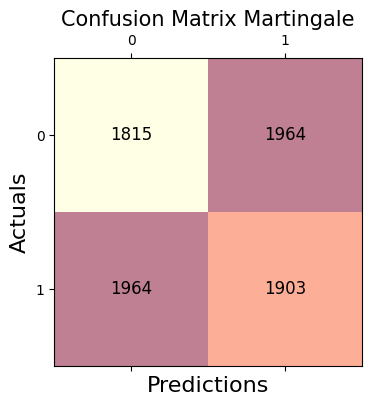

In [32]:
fig, px = plt.subplots(figsize=(4, 4))
px.matshow(confusion_mart, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mart.shape[0]):
    for n in range(confusion_mart.shape[1]):
        px.text(x=m,y=n,s=confusion_mart[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Martingale', fontsize=15)
plt.show()

<AxesSubplot:>

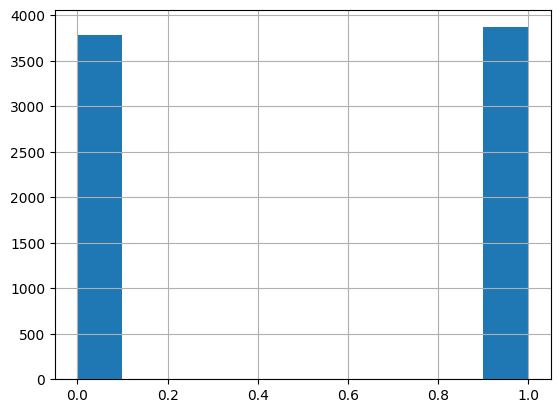

In [33]:
ohlc2['sign'].hist()

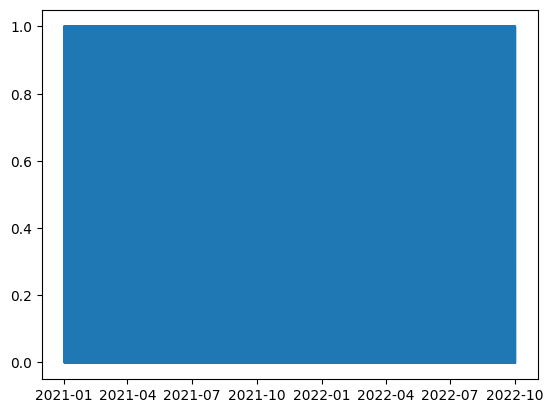

In [34]:
plt.plot(ohlc2['sign'])

{'whiskers': [<matplotlib.lines.Line2D at 0x255c63c8790>,
 'caps': [<matplotlib.lines.Line2D at 0x255c63c8d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x255c63c84c0>],
 'medians': [<matplotlib.lines.Line2D at 0x255c63c92d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x255c63c95a0>],
 'means': []}

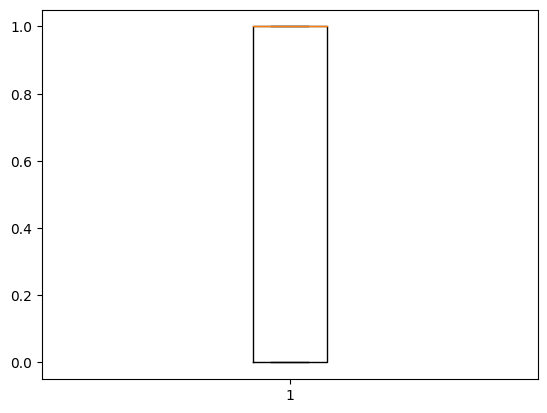

In [35]:
plt.boxplot(ohlc2['sign'], notch=None, vert=None, patch_artist=None, widths=None)

# <font color= #6B6B6B> 4.2. Feature Selection and feature transformation   </font>


Then we will apply different normalization and scaling methods to transform the data, then selecting the features to use on the following models, this because is a requirement for models like log regression, and also because we have different scales on the information.

                 open      high       low     close    volume  \
open         1.000000  0.999608  0.999380  0.999243 -0.460053   
high         0.999608  1.000000  0.999152  0.999617 -0.454050   
low          0.999380  0.999152  1.000000  0.999535 -0.470332   
close        0.999243  0.999617  0.999535  1.000000 -0.461394   
volume      -0.460053 -0.454050 -0.470332 -0.461394  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_10  -0.460715 -0.459203 -0.462620 -0.460572  0.578387   
sum_vol_10  -0.564721 -0.561685 -0.568775 -0.564579  0.790177   
mean_vol_10 -0.564721 -0.561685 -0.568775 -0.564579  0.790177   
sign        -0.008816 -0.009650 -0.010015 -0.010806  0.003555   
martingale   0.014992  0.014271  0.016801  0.014203 -0.020160   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.111191 -0.405948         -0.462916   
high                  -0.100965 -0.400613         -0.456220   
low                   -0.12866

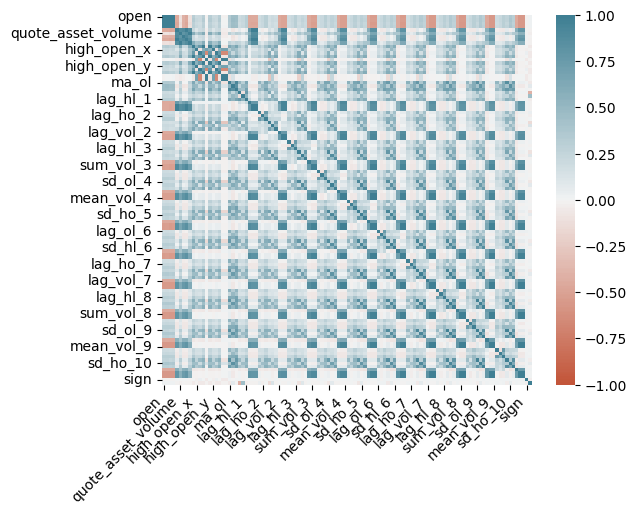

In [36]:
# Heat map
correlation = ohlc2.corr()
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

                 open      high       low     close    volume  \
open         1.000000  0.999427  0.999173  0.998943 -0.441189   
high         0.999427  1.000000  0.998859  0.999459 -0.430432   
low          0.999173  0.998859  1.000000  0.999381 -0.455188   
close        0.998943  0.999459  0.999381  1.000000 -0.441942   
volume      -0.441189 -0.430432 -0.455188 -0.441942  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_10  -0.442437 -0.438274 -0.447459 -0.442039  0.617126   
sum_vol_10  -0.513289 -0.506438 -0.521822 -0.512968  0.798100   
mean_vol_10 -0.513289 -0.506438 -0.521822 -0.512968  0.798100   
sign        -0.010404 -0.011700 -0.011823 -0.013081  0.006270   
martingale   0.016652  0.015992  0.018394  0.015630 -0.018029   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.051952 -0.223274         -0.443605   
high                  -0.040031 -0.213336         -0.432039   
low                   -0.06713

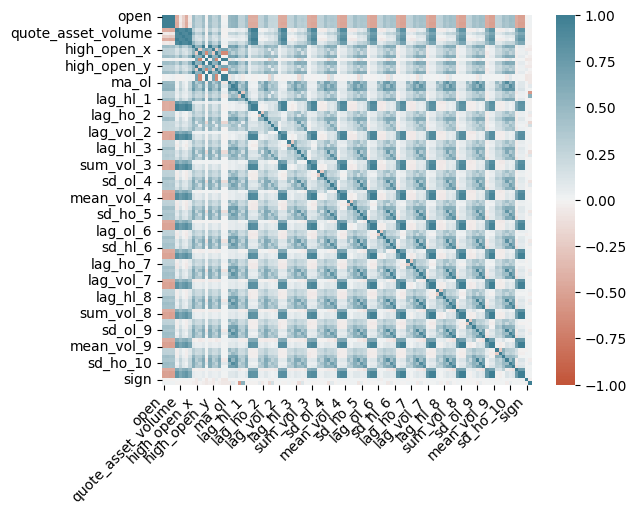

In [37]:
# Heat map spearman
correlation = ohlc2.corr(method= 'spearman')
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

                 open      high       low     close    volume  \
open         1.000000  0.983039  0.981062  0.974452 -0.299207   
high         0.983039  1.000000  0.976627  0.983417 -0.290923   
low          0.981062  0.976627  1.000000  0.982616 -0.309846   
close        0.974452  0.983417  0.982616  1.000000 -0.299695   
volume      -0.299207 -0.290923 -0.309846 -0.299695  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_10  -0.298939 -0.295860 -0.302487 -0.298448  0.443136   
sum_vol_10  -0.353162 -0.347737 -0.359868 -0.352830  0.608492   
mean_vol_10 -0.353162 -0.347737 -0.359868 -0.352830  0.608492   
sign        -0.008495 -0.009554 -0.009654 -0.010682  0.005120   
martingale   0.013597  0.013059  0.015020  0.012763 -0.014721   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.030318 -0.139569         -0.301177   
high                  -0.021975 -0.131877         -0.292275   
low                   -0.04090

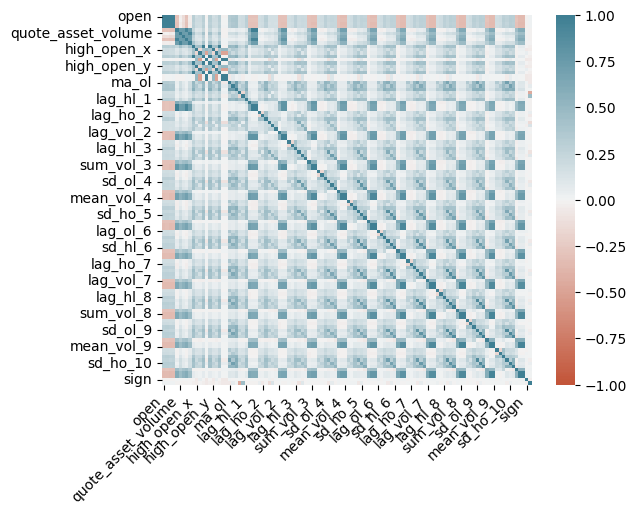

In [38]:
# Heat map kendall
correlation = ohlc2.corr(method = 'kendall')
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [39]:
X = ohlc2.iloc[:,:-2]
X.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 20:00:00  29029.04  29289.82  28880.37  29160.39  3285.778723   
2021-01-01 22:00:00  29163.17  29338.89  29104.57  29331.69  2098.159282   
2021-01-02 00:00:00  29331.70  29400.00  28946.53  29359.47  4530.156628   
2021-01-02 02:00:00  29359.46  29469.00  29256.85  29351.95  2862.871898   
2021-01-02 04:00:00  29351.95  29590.00  29220.00  29589.99  3767.589301   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2021-01-01 20:00:00        9.587546e+07  87130.0       1736.553056   
2021-01-01 22:00:00        6.141617e+07  66153.0       1076.233142   
2021-01-02 00:00:00        1.322419e+08  97923.0       2207.738188   
2021-01-02 02:00:00        8.407457e+07  68202.0       1482.934750   
2021-01-02 04:00:00        1.109437e+08  84796.0       2403.248668   

                     taker_buy_asset_volume  volatility_x  ...   mean_vol_9  \
timestamp                                                  ...                
2021-01-01 20:00:00            5.067730e+07        409.45  ...  4502.701020   
2021-01-01 22:00:00            3.150702e+07        234.32  ...  4346.051710   
2021-01-02 00:00:00            6.445830e+07        453.47  ...  4427.079424   
2021-01-02 02:00:00            4.355514e+07        212.15  ...  4297.373883   
2021-01-02 04:00:00            7.079202e+07        370.00  ...  4243.385632   

                     lag_ol_10  lag_ho_10  lag_hl_10    sd_ol_10   sd_ho_10  \
timestamp                                                                     
2021-01-01 20:00:00     233.46     546.37     779.83  129.458863  81.015533   
2021-01-01 22:00:00     289.97      55.26     345.23  144.159868  71.509485   
2021-01-02 00:00:00     249.01     116.59     365.60  151.260932  77.336072   
2021-01-02 02:00:00     380.47      82.99     463.46  151.084072  74.384112   
2021-01-02 04:00:00     220.60     214.89     435.49  154.058576  76.155366   

                       sd_hl_10   lag_vol_10    sum_vol_10  mean_vol_10  
timestamp                                                                
2021-01-01 20:00:00  101.591601  7714.879916  44369.885813  4436.988581  
2021-01-01 22:00:00  116.550569  3845.576637  42622.468458  4262.246846  
2021-01-02 00:00:00  115.584351  3508.003065  43644.622021  4364.462202  
2021-01-02 02:00:00  132.479158  3800.907209  42706.586710  4270.658671  
2021-01-02 04:00:00  132.163749  4030.221761  42443.954250  4244.395425  

[5 rows x 110 columns]

In [40]:
y = ohlc2['sign'].copy()
y_true = y.copy()
y.head()

timestamp
2021-01-01 20:00:00    1.0
2021-01-01 22:00:00    1.0
2021-01-02 00:00:00    0.0
2021-01-02 02:00:00    1.0
2021-01-02 04:00:00    1.0
Name: sign, dtype: float64

In [41]:
from gplearn.genetic import SymbolicTransformer                               # variables simbolicas


In [42]:
def genetic_programed_features(p_data, p_target, p_params):
    """
    El uso de programacion genetica para generar variables independientes simbolicas
    Parameters
    ----------
    p_data: pd.DataFrame
        con datos completos para ajustar modelos
        
        p_data = m_folds['periodo_1']
    p_split: int
        split in val
        p_split = '0'
    p_params:
        parameters for symbolic_features process 
    Returns
    -------
    model_data: dict
        {'train_x': pd.DataFrame, 'train_y': pd.DataFrame, 'val_x': pd.DataFrame, 'val_y': pd.DataFrame}
    References
    ----------
    https://stackoverflow.com/questions/3819977/
    what-are-the-differences-between-genetic-algorithms-and-genetic-programming
    """
   
    # separacion de variable dependiente
    datos_y = y.copy().astype(int)

    # separacion de variables independientes
    datos_had = X.copy()
    # Lista de operaciones simbolicas
    sym_data = symbolic_features(p_x=datos_had, p_y=datos_y, p_params=p_params)

    # Symbolic variables output
    datos_sym = sym_data['data'].copy()
    datos_sym.columns = ['sym_' + str(i) for i in range(0, len(sym_data['data'].iloc[0, :]))]
    datos_sym.index = datos_y.index
   
    return {'sym_data': sym_data, 'sym_features': datos_sym}


In [43]:
genetic_prog = genetic_programed_features(p_data=X, p_target=y, p_params=symbolic_params)

# Process description
sym_process = pd.DataFrame(genetic_prog['sym_data']['details'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.48       0.00957984        3        0.0707664              N/A     40.15s
   1     2.92        0.0139591        3        0.0666363              N/A     13.37s
   2     2.40        0.0172437        3        0.0707664              N/A     10.46s
   3     2.19        0.0253186        3        0.0649348              N/A      4.61s
   4     2.10         0.036956        3        0.0531509              N/A      0.00s


In [44]:
sym_features = genetic_prog['sym_features']
sym_features

sym_0     sym_1   sym_2   sym_3   sym_4   sym_5  \
timestamp                                                                   
2021-01-01 20:00:00  -55.502739  1.439543  131.35  131.35  131.35  131.35   
2021-01-01 22:00:00  -95.939643  0.479742  168.52  168.52  168.52  168.52   
2021-01-02 00:00:00   47.438971  3.163015   27.77   27.77   27.77   27.77   
2021-01-02 02:00:00   84.883898  0.733445   -7.51   -7.51   -7.51   -7.51   
2021-01-02 04:00:00 -157.784487  1.018961  238.04  238.04  238.04  238.04   
...                         ...       ...     ...     ...     ...     ...   
2022-09-30 14:00:00  -68.302633  0.184228  283.92  283.92  283.92  283.92   
2022-09-30 16:00:00  292.586741  0.993128  -76.69  -76.69  -76.69  -76.69   
2022-09-30 18:00:00  421.006152  1.078451 -205.81 -205.81 -205.81 -205.81   
2022-09-30 20:00:00  322.588735  0.986585 -112.45 -112.45 -112.45 -112.45   
2022-09-30 22:00:00  146.694810  0.663420   62.84   62.84   62.84   62.84   

                      sym_6   sym_7   sym_8   sym_9  sym_10  sym_11  sym_12  \
timestamp                                                                     
2021-01-01 20:00:00  131.35  131.35  131.35  131.35  131.35  131.35  131.35   
2021-01-01 22:00:00  168.52  168.52  168.52  168.52  168.52  168.52  168.52   
2021-01-02 00:00:00   27.77   27.77   27.77   27.77   27.77   27.77   27.77   
2021-01-02 02:00:00   -7.51   -7.51   -7.51   -7.51   -7.51   -7.51   -7.51   
2021-01-02 04:00:00  238.04  238.04  238.04  238.04  238.04  238.04  238.04   
...                     ...     ...     ...     ...     ...     ...     ...   
2022-09-30 14:00:00  283.92  283.92  283.92  283.92  283.92  283.92  283.92   
2022-09-30 16:00:00  -76.69  -76.69  -76.69  -76.69  -76.69  -76.69  -76.69   
2022-09-30 18:00:00 -205.81 -205.81 -205.81 -205.81 -205.81 -205.81 -205.81   
2022-09-30 20:00:00 -112.45 -112.45 -112.45 -112.45 -112.45 -112.45 -112.45   
2022-09-30 22:00:00   62.84   62.84   62.84   62.84   62.84   62.84   62.84   

                     sym_13  sym_14  sym_15  sym_16  sym_17  sym_18  sym_19  
timestamp                                                                    
2021-01-01 20:00:00  131.35  131.35  131.35  131.35  131.35  131.35  131.35  
2021-01-01 22:00:00  168.52  168.52  168.52  168.52  168.52  168.52  168.52  
2021-01-02 00:00:00   27.77   27.77   27.77   27.77   27.77   27.77   27.77  
2021-01-02 02:00:00   -7.51   -7.51   -7.51   -7.51   -7.51   -7.51   -7.51  
2021-01-02 04:00:00  238.04  238.04  238.04  238.04  238.04  238.04  238.04  
...                     ...     ...     ...     ...     ...     ...     ...  
2022-09-30 14:00:00  283.92  283.92  283.92  283.92  283.92  283.92  283.92  
2022-09-30 16:00:00  -76.69  -76.69  -76.69  -76.69  -76.69  -76.69  -76.69  
2022-09-30 18:00:00 -205.81 -205.81 -205.81 -205.81 -205.81 -205.81 -205.81  
2022-09-30 20:00:00 -112.45 -112.45 -112.45 -112.45 -112.45 -112.45 -112.45  
2022-09-30 22:00:00   62.84   62.84   62.84   62.84   62.84   62.84   62.84  

[7646 rows x 20 columns]

We now perform a chi squared test, to se the relevant features

To use the data in the log regression we require to fit the data trought transformations as the data has different scales which would give us a bad forecast.

* The first one is the Normalizer which transforms numeric columns to a standard scale. in this instance it is done by the maximum absolute scaling method which has the following formula:
$$ x_{scaled} =\frac{ x}{max(|x|)} $$

In [45]:
# Normalizer
transformer = Normalizer(norm= 'max').fit(X) 
transformed = transformer.transform(X)
X_normalized = pd.DataFrame(transformed,index = X.index, columns= X.columns)
X_normalized.head()

open      high       low     close    volume  \
timestamp                                                               
2021-01-01 20:00:00  0.000303  0.000305  0.000301  0.000304  0.000034   
2021-01-01 22:00:00  0.000475  0.000478  0.000474  0.000478  0.000034   
2021-01-02 00:00:00  0.000222  0.000222  0.000219  0.000222  0.000034   
2021-01-02 02:00:00  0.000349  0.000351  0.000348  0.000349  0.000034   
2021-01-02 04:00:00  0.000265  0.000267  0.000263  0.000267  0.000034   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 20:00:00                 1.0  0.000909          0.000018   
2021-01-01 22:00:00                 1.0  0.001077          0.000018   
2021-01-02 00:00:00                 1.0  0.000740          0.000017   
2021-01-02 02:00:00                 1.0  0.000811          0.000018   
2021-01-02 04:00:00                 1.0  0.000764          0.000022   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2021-01-01 20:00:00                0.528574      0.000004  ...    0.000047   
2021-01-01 22:00:00                0.513009      0.000004  ...    0.000071   
2021-01-02 00:00:00                0.487427      0.000003  ...    0.000033   
2021-01-02 02:00:00                0.518054      0.000003  ...    0.000051   
2021-01-02 04:00:00                0.638089      0.000003  ...    0.000038   

                     lag_ol_10     lag_ho_10  lag_hl_10  sd_ol_10  \
timestamp                                                           
2021-01-01 20:00:00   0.000002  5.698747e-06   0.000008  0.000001   
2021-01-01 22:00:00   0.000005  8.997631e-07   0.000006  0.000002   
2021-01-02 00:00:00   0.000002  8.816417e-07   0.000003  0.000001   
2021-01-02 02:00:00   0.000005  9.870999e-07   0.000006  0.000002   
2021-01-02 04:00:00   0.000002  1.936928e-06   0.000004  0.000001   

                         sd_ho_10      sd_hl_10  lag_vol_10  sum_vol_10  \
timestamp                                                                 
2021-01-01 20:00:00  8.450080e-07  1.059620e-06    0.000080    0.000463   
2021-01-01 22:00:00  1.164343e-06  1.897718e-06    0.000063    0.000694   
2021-01-02 00:00:00  5.848075e-07  8.740371e-07    0.000027    0.000330   
2021-01-02 02:00:00  8.847397e-07  1.575734e-06    0.000045    0.000508   
2021-01-02 04:00:00  6.864324e-07  1.191268e-06    0.000036    0.000383   

                     mean_vol_10  
timestamp                         
2021-01-01 20:00:00     0.000046  
2021-01-01 22:00:00     0.000069  
2021-01-02 00:00:00     0.000033  
2021-01-02 02:00:00     0.000051  
2021-01-02 04:00:00     0.000038  

[5 rows x 110 columns]

The second method chosen was Min Max Scaler, which transforms the features by scaling them to a given range in this case 0 to 1.

$$ X_{norm}= \frac{X-X_{min}} {X_{max}-X_{min}} $$

In [46]:
#  Min Max Scaler
scale = MinMaxScaler()
X_scale = scale.fit(X)
X_scale = scale.transform(X)
X_scale = pd.DataFrame(X_scale,index = X.index, columns= X.columns)
X_scale.head()

open      high       low     close    volume  \
timestamp                                                               
2021-01-01 20:00:00  0.422947  0.424490  0.422575  0.424870  0.015964   
2021-01-01 22:00:00  0.424902  0.425201  0.425855  0.427366  0.010194   
2021-01-02 00:00:00  0.427357  0.426087  0.423543  0.427771  0.022009   
2021-01-02 02:00:00  0.427761  0.427087  0.428083  0.427661  0.013909   
2021-01-02 04:00:00  0.427652  0.428841  0.427544  0.431129  0.018304   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 20:00:00            0.021358  0.054254          0.016861   
2021-01-01 22:00:00            0.013681  0.041192          0.010450   
2021-01-02 00:00:00            0.029459  0.060975          0.021436   
2021-01-02 02:00:00            0.018729  0.042468          0.014399   
2021-01-02 04:00:00            0.024714  0.052801          0.023335   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2021-01-01 20:00:00                0.022562      0.038603  ...    0.067343   
2021-01-01 22:00:00                0.014027      0.022092  ...    0.064338   
2021-01-02 00:00:00                0.028697      0.042753  ...    0.065892   
2021-01-02 02:00:00                0.019391      0.020002  ...    0.063405   
2021-01-02 04:00:00                0.031517      0.034884  ...    0.062370   

                     lag_ol_10  lag_ho_10  lag_hl_10  sd_ol_10  sd_ho_10  \
timestamp                                                                  
2021-01-01 20:00:00   0.023347   0.095458   0.073523  0.037054  0.038645   
2021-01-01 22:00:00   0.028998   0.009655   0.032548  0.041905  0.033085   
2021-01-02 00:00:00   0.024902   0.020370   0.034469  0.044249  0.036493   
2021-01-02 02:00:00   0.038048   0.014500   0.043695  0.044190  0.034766   
2021-01-02 04:00:00   0.022061   0.037544   0.041058  0.045172  0.035802   

                     sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                                           
2021-01-01 20:00:00  0.024293    0.037482    0.066044     0.066044  
2021-01-01 22:00:00  0.029321    0.018683    0.062673     0.062673  
2021-01-02 00:00:00  0.028996    0.017043    0.064645     0.064645  
2021-01-02 02:00:00  0.034675    0.018466    0.062836     0.062836  
2021-01-02 04:00:00  0.034569    0.019580    0.062329     0.062329  

[5 rows x 110 columns]

The last one is the standardization method, which removes the mean and sacales to unit variance.

$$ Z=\frac{(X-u)}{S} $$
where:
* U = mean of the training samples 
* S= Standard deviation

In [47]:
# Standardize
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X_standard = pd.DataFrame(scaled,index = X.index, columns= X.columns)
X_standard.head()

open      high       low     close    volume  \
timestamp                                                               
2021-01-01 20:00:00 -0.922704 -0.922800 -0.912183 -0.911993 -0.517377   
2021-01-01 22:00:00 -0.911996 -0.918907 -0.894155 -0.898319 -0.667274   
2021-01-02 00:00:00 -0.898541 -0.914058 -0.906863 -0.896101 -0.360316   
2021-01-02 02:00:00 -0.896325 -0.908584 -0.881910 -0.896702 -0.570755   
2021-01-02 04:00:00 -0.896925 -0.898984 -0.884873 -0.877700 -0.456564   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 20:00:00           -0.800530 -0.613749         -0.486288   
2021-01-01 22:00:00           -0.975159 -0.753293         -0.653938   
2021-01-02 00:00:00           -0.616237 -0.541951         -0.366657   
2021-01-02 02:00:00           -0.860333 -0.739663         -0.550679   
2021-01-02 04:00:00           -0.724169 -0.629275         -0.317019   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_9  \
timestamp                                                  ...               
2021-01-01 20:00:00               -0.765997     -0.529817  ...   -0.440437   
2021-01-01 22:00:00               -0.962696     -0.852681  ...   -0.464526   
2021-01-02 00:00:00               -0.624596     -0.448663  ...   -0.452066   
2021-01-02 02:00:00               -0.839075     -0.893553  ...   -0.472012   
2021-01-02 04:00:00               -0.559608     -0.602546  ...   -0.480314   

                     lag_ol_10  lag_ho_10  lag_hl_10  sd_ol_10  sd_ho_10  \
timestamp                                                                  
2021-01-01 20:00:00  -0.288492   0.589089   0.152629 -0.658683 -1.085913   
2021-01-01 22:00:00  -0.162549  -0.774200  -0.648797 -0.601435 -1.138731   
2021-01-02 00:00:00  -0.253836  -0.603952  -0.611234 -0.573783 -1.106357   
2021-01-02 02:00:00   0.039147  -0.697224  -0.430775 -0.574472 -1.122759   
2021-01-02 04:00:00  -0.317153  -0.331078  -0.482353 -0.562888 -1.112917   

                     sd_hl_10  lag_vol_10  sum_vol_10  mean_vol_10  
timestamp                                                           
2021-01-01 20:00:00 -0.844841    0.047768   -0.453956    -0.453956  
2021-01-01 22:00:00 -0.787422   -0.447404   -0.481053    -0.481053  
2021-01-02 00:00:00 -0.791130   -0.490605   -0.465203    -0.465203  
2021-01-02 02:00:00 -0.726280   -0.453120   -0.479749    -0.479749  
2021-01-02 04:00:00 -0.727491   -0.423774   -0.483821    -0.483821  

[5 rows x 110 columns]

                 open      high       low     close    volume  \
open         1.000000  1.000000  1.000000  1.000000 -0.044215   
high         1.000000  1.000000  1.000000  1.000000 -0.044363   
low          1.000000  1.000000  1.000000  1.000000 -0.044013   
close        1.000000  1.000000  1.000000  1.000000 -0.044181   
volume      -0.044215 -0.044363 -0.044013 -0.044181  1.000000   
...               ...       ...       ...       ...       ...   
sd_ho_10     0.040886  0.040865  0.040912  0.040891 -0.091908   
sd_hl_10     0.029889  0.029868  0.029916  0.029894 -0.093746   
lag_vol_10   0.024792  0.024771  0.024819  0.024797 -0.088765   
sum_vol_10   0.037422  0.037399  0.037451  0.037428 -0.093565   
mean_vol_10  0.037422  0.037399  0.037451  0.037428 -0.093565   

             quote_asset_volume    trades  buy_asset_volume  \
open                   0.005017  0.002409         -0.033914   
high                   0.005039  0.002283         -0.034022   
low                    0.00498

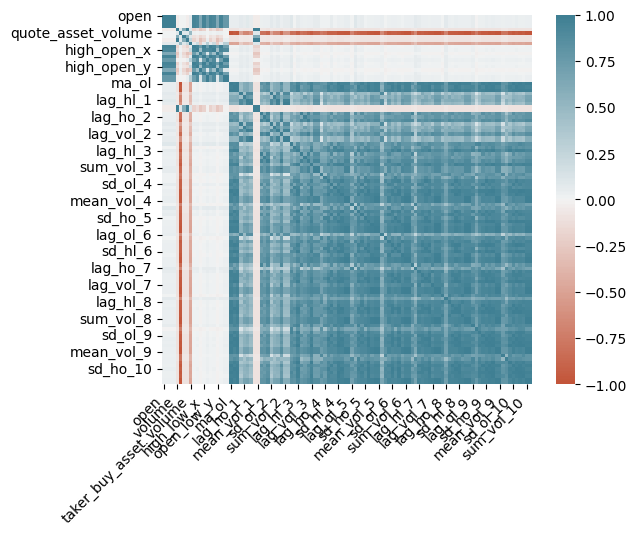

In [48]:
# Heat map
correlation = X_normalized.corr()
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

                 open      high       low     close  volume  \
open         1.000000  0.935065  0.896104  0.870130     NaN   
high         0.935065  1.000000  0.883117  0.935065     NaN   
low          0.896104  0.883117  1.000000  0.974026     NaN   
close        0.870130  0.935065  0.974026  1.000000     NaN   
volume            NaN       NaN       NaN       NaN     1.0   
...               ...       ...       ...       ...     ...   
sd_ho_10          NaN       NaN       NaN       NaN     NaN   
sd_hl_10          NaN       NaN       NaN       NaN     NaN   
lag_vol_10        NaN       NaN       NaN       NaN     NaN   
sum_vol_10        NaN       NaN       NaN       NaN     NaN   
mean_vol_10       NaN       NaN       NaN       NaN     NaN   

             quote_asset_volume  trades  buy_asset_volume  \
open                        NaN     NaN               NaN   
high                        NaN     NaN               NaN   
low                         NaN     NaN               NaN   

<AxesSubplot:>

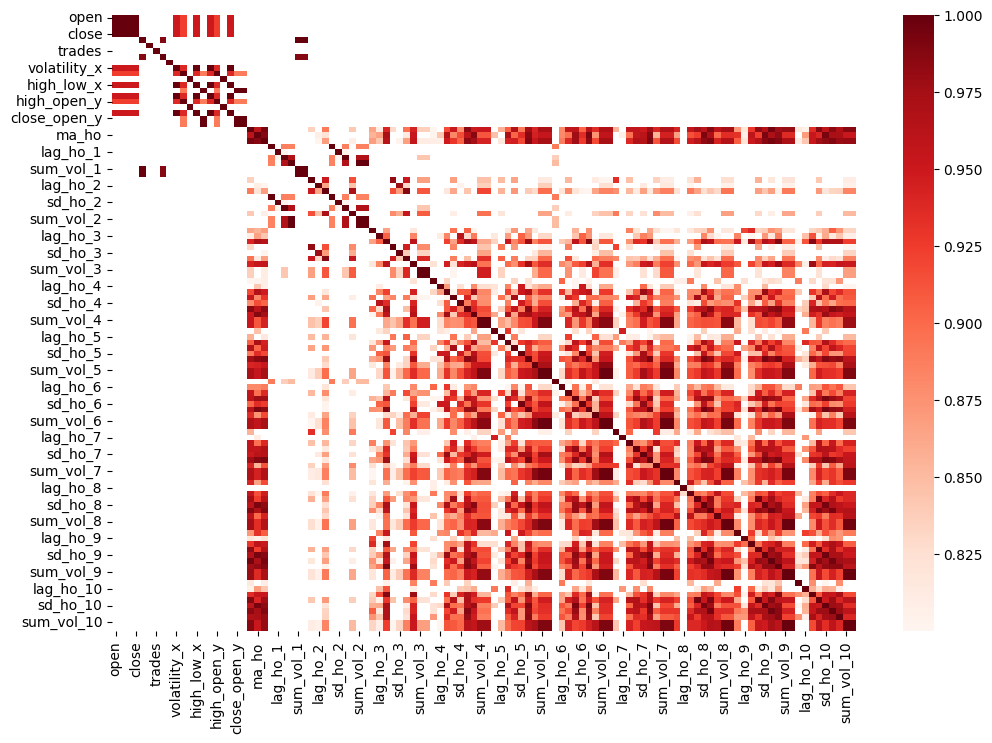

In [49]:
corr = correlation[correlation>=.80]
corr2 = corr.corr(method ='spearman')
print(corr2)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Reds")

                 open      high       low     close  volume  \
open         1.000000  0.935065  0.896104  0.870130     NaN   
high         0.935065  1.000000  0.883117  0.935065     NaN   
low          0.896104  0.883117  1.000000  0.974026     NaN   
close        0.870130  0.935065  0.974026  1.000000     NaN   
volume            NaN       NaN       NaN       NaN     1.0   
...               ...       ...       ...       ...     ...   
sd_ho_10          NaN       NaN       NaN       NaN     NaN   
sd_hl_10          NaN       NaN       NaN       NaN     NaN   
lag_vol_10        NaN       NaN       NaN       NaN     NaN   
sum_vol_10        NaN       NaN       NaN       NaN     NaN   
mean_vol_10       NaN       NaN       NaN       NaN     NaN   

             quote_asset_volume  trades  buy_asset_volume  \
open                        NaN     NaN               NaN   
high                        NaN     NaN               NaN   
low                         NaN     NaN               NaN   

<AxesSubplot:>

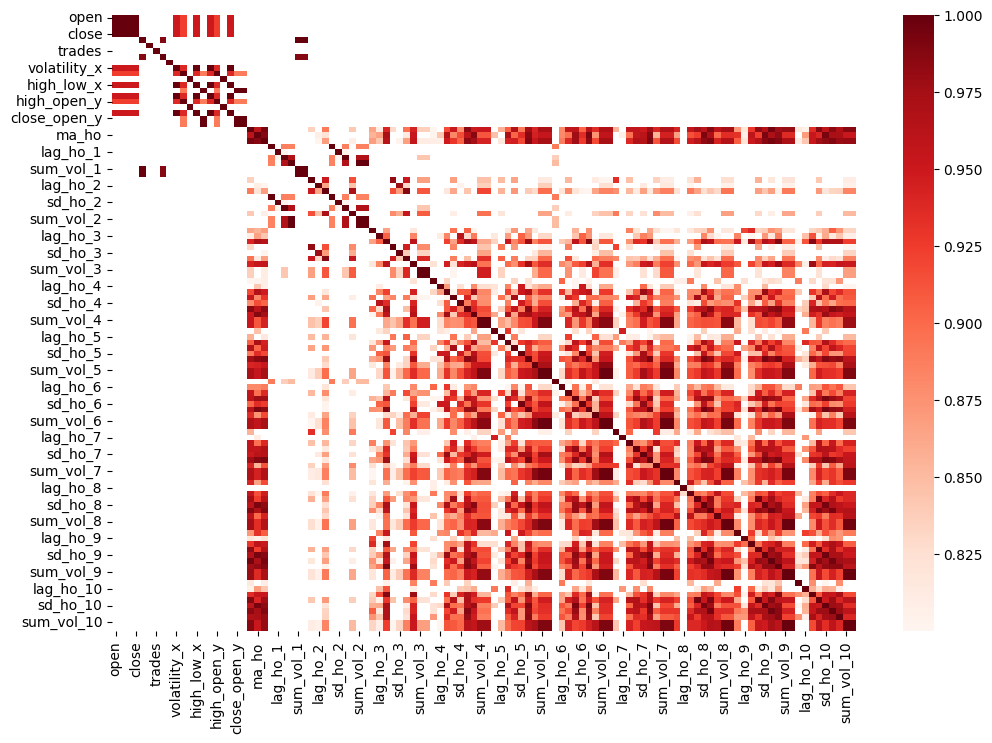

In [50]:
corr = correlation[correlation>=.80]
corr2 = corr.corr(method ='spearman')
print(corr2)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Reds")

In [51]:
cor_matrix = X_normalized.corr().abs()
print(cor_matrix)

                 open      high       low     close    volume  \
open         1.000000  1.000000  1.000000  1.000000  0.044215   
high         1.000000  1.000000  1.000000  1.000000  0.044363   
low          1.000000  1.000000  1.000000  1.000000  0.044013   
close        1.000000  1.000000  1.000000  1.000000  0.044181   
volume       0.044215  0.044363  0.044013  0.044181  1.000000   
...               ...       ...       ...       ...       ...   
sd_ho_10     0.040886  0.040865  0.040912  0.040891  0.091908   
sd_hl_10     0.029889  0.029868  0.029916  0.029894  0.093746   
lag_vol_10   0.024792  0.024771  0.024819  0.024797  0.088765   
sum_vol_10   0.037422  0.037399  0.037451  0.037428  0.093565   
mean_vol_10  0.037422  0.037399  0.037451  0.037428  0.093565   

             quote_asset_volume    trades  buy_asset_volume  \
open                   0.005017  0.002409          0.033914   
high                   0.005039  0.002283          0.034022   
low                    0.00498

In [52]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

             open  high  low  close    volume  quote_asset_volume    trades  \
open          NaN   1.0  1.0    1.0  0.044215            0.005017  0.002409   
high          NaN   NaN  1.0    1.0  0.044363            0.005039  0.002283   
low           NaN   NaN  NaN    1.0  0.044013            0.004989  0.002547   
close         NaN   NaN  NaN    NaN  0.044181            0.005012  0.002406   
volume        NaN   NaN  NaN    NaN       NaN            0.096497  0.609236   
...           ...   ...  ...    ...       ...                 ...       ...   
sd_ho_10      NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
sd_hl_10      NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
lag_vol_10    NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
sum_vol_10    NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
mean_vol_10   NaN   NaN  NaN    NaN       NaN                 NaN       NaN   

             buy_asset_volume  taker_buy_asset_volu

C:\Users\Emilio\AppData\Local\Temp\ipykernel_8384\3477284062.py:1: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [53]:
#.5 according to JF, but not many features after that.
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= .85)]
print(); print(to_drop)


['high', 'low', 'close', 'buy_asset_volume', 'volatility_x', 'high_open_x', 'high_low_x', 'close_open_x', 'volatility_y', 'high_open_y', 'open_low_y', 'high_low_y', 'close_open_y', 'co', 'ma_ol', 'ma_ho', 'ma_hl', 'lag_hl_1', 'lag_vol_1', 'sum_vol_1', 'mean_vol_1', 'lag_hl_2', 'sd_ol_2', 'sd_ho_2', 'sd_hl_2', 'lag_vol_2', 'sum_vol_2', 'mean_vol_2', 'lag_ol_3', 'lag_ho_3', 'lag_hl_3', 'sd_ol_3', 'sd_ho_3', 'sd_hl_3', 'lag_vol_3', 'sum_vol_3', 'mean_vol_3', 'lag_hl_4', 'sd_ol_4', 'sd_ho_4', 'sd_hl_4', 'lag_vol_4', 'sum_vol_4', 'mean_vol_4', 'lag_ol_5', 'lag_ho_5', 'lag_hl_5', 'sd_ol_5', 'sd_ho_5', 'sd_hl_5', 'lag_vol_5', 'sum_vol_5', 'mean_vol_5', 'lag_ol_6', 'lag_ho_6', 'lag_hl_6', 'sd_ol_6', 'sd_ho_6', 'sd_hl_6', 'lag_vol_6', 'sum_vol_6', 'mean_vol_6', 'lag_ol_7', 'lag_ho_7', 'lag_hl_7', 'sd_ol_7', 'sd_ho_7', 'sd_hl_7', 'lag_vol_7', 'sum_vol_7', 'mean_vol_7', 'lag_ol_8', 'lag_hl_8', 'sd_ol_8', 'sd_ho_8', 'sd_hl_8', 'lag_vol_8', 'sum_vol_8', 'mean_vol_8', 'lag_ol_9', 'lag_ho_9', 'lag_h

In [54]:
#x = X_standard.copy()
x = X_scale.copy()
#x = X_normalized.copy()
#x = X.copy()

In [55]:
x = x.drop(x[to_drop],axis=1)
print(); print(x.head())
x.head()


                         open    volume  quote_asset_volume    trades  \
timestamp                                                               
2021-01-01 20:00:00  0.422947  0.015964            0.021358  0.054254   
2021-01-01 22:00:00  0.424902  0.010194            0.013681  0.041192   
2021-01-02 00:00:00  0.427357  0.022009            0.029459  0.060975   
2021-01-02 02:00:00  0.427761  0.013909            0.018729  0.042468   
2021-01-02 04:00:00  0.427652  0.018304            0.024714  0.052801   

                     taker_buy_asset_volume  open_low_x  lag_ol_1  lag_ho_1  \
timestamp                                                                     
2021-01-01 20:00:00                0.022562    0.014867  0.045303  0.031866   
2021-01-01 22:00:00                0.014027    0.005860  0.014867  0.045562   
2021-01-02 00:00:00                0.028697    0.038518  0.005860  0.030701   
2021-01-02 02:00:00                0.019391    0.010261  0.038518  0.011933   
2021-01-02 04

open    volume  quote_asset_volume    trades  \
timestamp                                                               
2021-01-01 20:00:00  0.422947  0.015964            0.021358  0.054254   
2021-01-01 22:00:00  0.424902  0.010194            0.013681  0.041192   
2021-01-02 00:00:00  0.427357  0.022009            0.029459  0.060975   
2021-01-02 02:00:00  0.427761  0.013909            0.018729  0.042468   
2021-01-02 04:00:00  0.427652  0.018304            0.024714  0.052801   

                     taker_buy_asset_volume  open_low_x  lag_ol_1  lag_ho_1  \
timestamp                                                                     
2021-01-01 20:00:00                0.022562    0.014867  0.045303  0.031866   
2021-01-01 22:00:00                0.014027    0.005860  0.014867  0.045562   
2021-01-02 00:00:00                0.028697    0.038518  0.005860  0.030701   
2021-01-02 02:00:00                0.019391    0.010261  0.038518  0.011933   
2021-01-02 04:00:00                0.031517    0.013195  0.010261  0.019138   

                     lag_ol_2  lag_ho_2  lag_ol_4  lag_ho_4  lag_ho_8  
timestamp                                                              
2021-01-01 20:00:00  0.025168  0.029934  0.016349  0.050057  0.020370  
2021-01-01 22:00:00  0.045303  0.031866  0.043466  0.011393  0.014500  
2021-01-02 00:00:00  0.014867  0.045562  0.025168  0.029934  0.037544  
2021-01-02 02:00:00  0.005860  0.030701  0.045303  0.031866  0.035006  
2021-01-02 04:00:00  0.038518  0.011933  0.014867  0.045562  0.050057

In [56]:
x

open    volume  quote_asset_volume    trades  \
timestamp                                                               
2021-01-01 20:00:00  0.422947  0.015964            0.021358  0.054254   
2021-01-01 22:00:00  0.424902  0.010194            0.013681  0.041192   
2021-01-02 00:00:00  0.427357  0.022009            0.029459  0.060975   
2021-01-02 02:00:00  0.427761  0.013909            0.018729  0.042468   
2021-01-02 04:00:00  0.427652  0.018304            0.024714  0.052801   
...                       ...       ...                 ...       ...   
2022-09-30 14:00:00  0.283704  0.413766            0.376855  0.711487   
2022-09-30 16:00:00  0.287841  0.224160            0.202610  0.429308   
2022-09-30 18:00:00  0.286724  0.169411            0.152927  0.318432   
2022-09-30 20:00:00  0.283725  0.131856            0.117395  0.272874   
2022-09-30 22:00:00  0.282068  0.113775            0.101054  0.189397   

                     taker_buy_asset_volume  open_low_x  lag_ol_1  lag_ho_1  \
timestamp                                                                     
2021-01-01 20:00:00                0.022562    0.014867  0.045303  0.031866   
2021-01-01 22:00:00                0.014027    0.005860  0.014867  0.045562   
2021-01-02 00:00:00                0.028697    0.038518  0.005860  0.030701   
2021-01-02 02:00:00                0.019391    0.010261  0.038518  0.011933   
2021-01-02 04:00:00                0.031517    0.013195  0.010261  0.019138   
...                                     ...         ...       ...       ...   
2022-09-30 14:00:00                0.369850    0.003560  0.028044  0.011900   
2022-09-30 16:00:00                0.197342    0.019051  0.003560  0.124555   
2022-09-30 18:00:00                0.147048    0.020905  0.019051  0.020525   
2022-09-30 20:00:00                0.114199    0.018868  0.020905  0.027785   
2022-09-30 22:00:00                0.100756    0.011933  0.018868  0.012090   

                     lag_ol_2  lag_ho_2  lag_ol_4  lag_ho_4  lag_ho_8  
timestamp                                                              
2021-01-01 20:00:00  0.025168  0.029934  0.016349  0.050057  0.020370  
2021-01-01 22:00:00  0.045303  0.031866  0.043466  0.011393  0.014500  
2021-01-02 00:00:00  0.014867  0.045562  0.025168  0.029934  0.037544  
2021-01-02 02:00:00  0.005860  0.030701  0.045303  0.031866  0.035006  
2021-01-02 04:00:00  0.038518  0.011933  0.014867  0.045562  0.050057  
...                       ...       ...       ...       ...       ...  
2022-09-30 14:00:00  0.012770  0.005958  0.005246  0.033893  0.032948  
2022-09-30 16:00:00  0.028044  0.011900  0.007963  0.011320  0.019124  
2022-09-30 18:00:00  0.003560  0.124555  0.012770  0.005958  0.000453  
2022-09-30 20:00:00  0.019051  0.020525  0.028044  0.011900  0.017354  
2022-09-30 22:00:00  0.020905  0.027785  0.003560  0.124555  0.033893  

[7646 rows x 13 columns]

The logistic Regression was chosen because of the type of target variable which is  categorical feature. 
* The cost function in this case is the following one:
$$ \underset{w,c}{min}\frac{1-p}{2}{w}^{T}w+\rho||w||_1+C\sum_{i=1}^{n}log(exp(-y_i(\mathrm{X}_{i}^{T}w+c))+1) $$

This cost function is the one used for Elastic Net regularization, which is a combination of the L1 and L2 penalizations.

Next we split the dataset, as this is a timeseries we require to split it without changing the timeline or it would influence the forecasting.

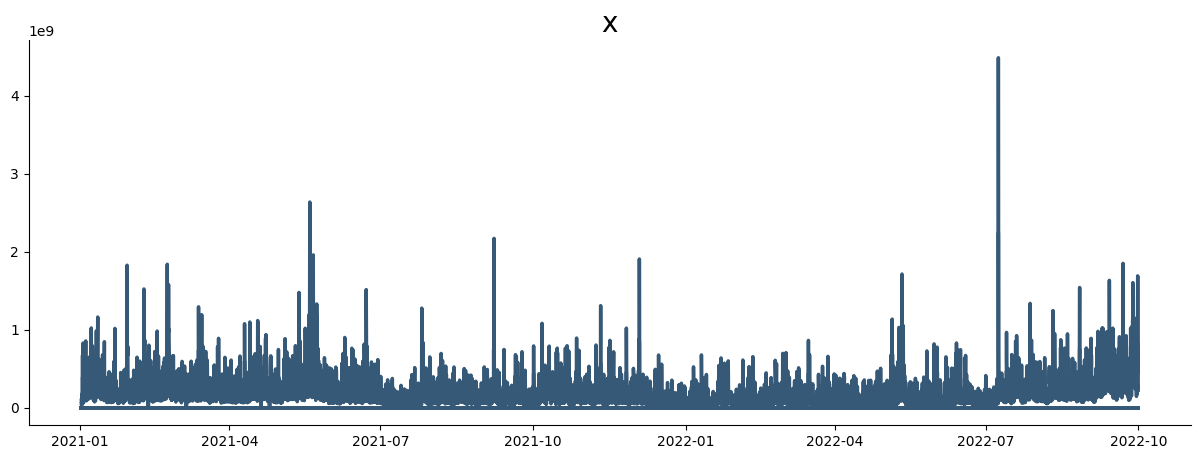

In [57]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5
plt.title('x',size=20)
plt.plot(X)

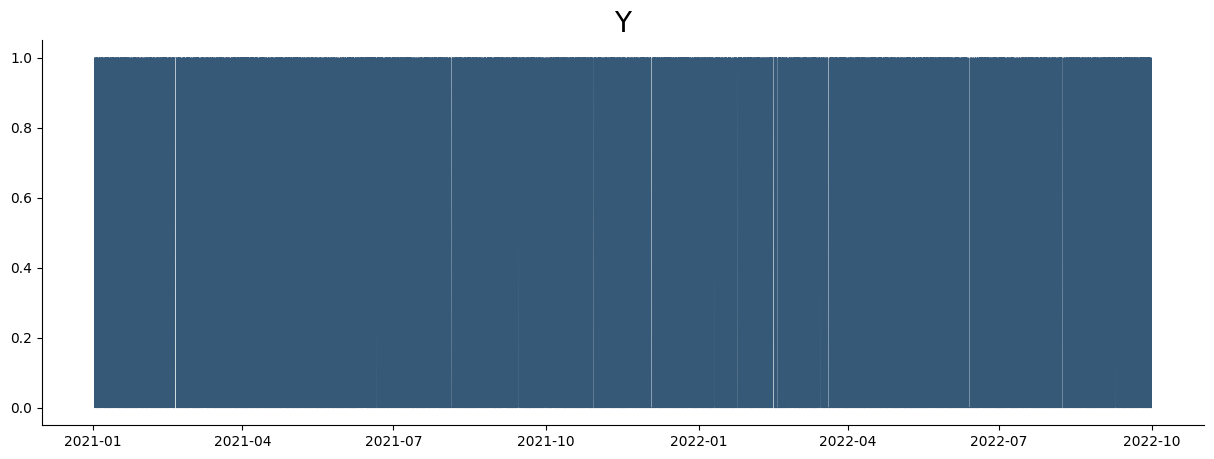

In [58]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = .5
plt.title('Y',size=20)
plt.plot(y)

In [59]:
test_size = int(len(x)*.20)

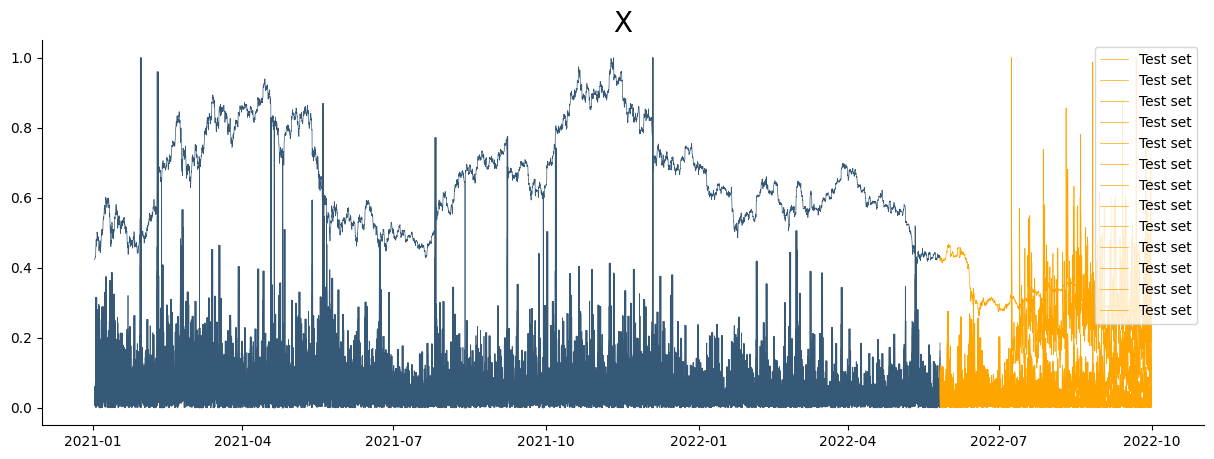

In [60]:
X_train = x[:-test_size].copy()
X_test = x[-test_size:].copy()
X_train2 =  x[:-test_size].copy()
X_test2 = x[-test_size:].copy()
X_train3 =  x[:-test_size].copy()
X_test3 = x[-test_size:].copy()

plt.title('X', size=20)
plt.plot(X_train) #,label='Training set')
plt.plot(X_test, label='Test set', color='orange')
plt.legend(loc = 'upper right');

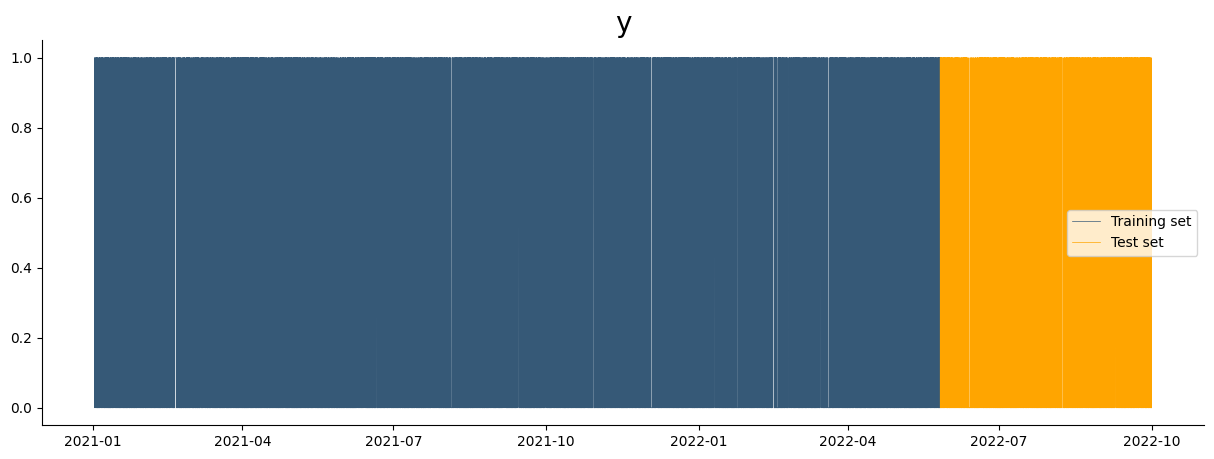

In [61]:
y_train = y[:-test_size].copy()
y_test = y[-test_size:].copy()
y_train2 = y[:-test_size].copy()
y_test2 = y[-test_size:].copy()



plt.title('y', size=20)
plt.plot(y_train, label='Training set')
plt.plot(y_test, label='Test set', color='orange')
plt.legend();

Now we apply the logistic regression, with the following parameters:
* C': 1,
* class_weight': None,
* dual': False,
* fit_intercept': True,
* intercept_scaling': 1,
* l1_ratio': 0.56,
* max_iter': 4000,
* multi_class': 'auto',
* penalty': 'elasticnet',
* random_state': False,
* solver': 'saga',
* tol': 0.0001,
* verbose': 0,
* warm_start': False}

In [62]:
# model fit
logistic_model = LogisticRegression(random_state=False, penalty='elasticnet',
                                    solver='saga', l1_ratio=.56, max_iter=1000000, C=1,
                                    class_weight = None,)
logistic_model.fit(X_train, y_train)

# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
logistic_model.score(x, y)
confusion_mat = confusion_matrix(y_test, y_pred)
print(accuracy)

48.463047743623285


In [63]:
logistic_model.get_params(deep=True)

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.56,
 'max_iter': 1000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'elasticnet',
 'random_state': False,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [64]:
# si fueron 0 se quitaron por efecto de la regularizacion L1 y son:
# si 
coef = logistic_model.coef_
print(logistic_model.intercept_)
coef

[0.15843831]


array([[-0.28186235,  0.        ,  0.        , -0.65783599, -0.00238743,
         1.47836287,  0.69473326, -0.05015643, -0.68234805,  0.        ,
         0.51073486,  0.44432128,  0.04084108]])

In [65]:
predict_ = logistic_model.predict_proba(X_train)
predict_
# ver como funciona con cada clase, resultados no son fuertes, 
# 1) analisis de los coeficientes por efectos de la regularizacion ( estos se quitaron , estos se redujeron)
# 2) analisis probabilistico para cada clase.

array([[0.48261037, 0.51738963],
       [0.49370235, 0.50629765],
       [0.48130359, 0.51869641],
       ...,
       [0.46898784, 0.53101216],
       [0.47838104, 0.52161896],
       [0.49122024, 0.50877976]])

(1.0, 30000.0, -3.0, 3.0)

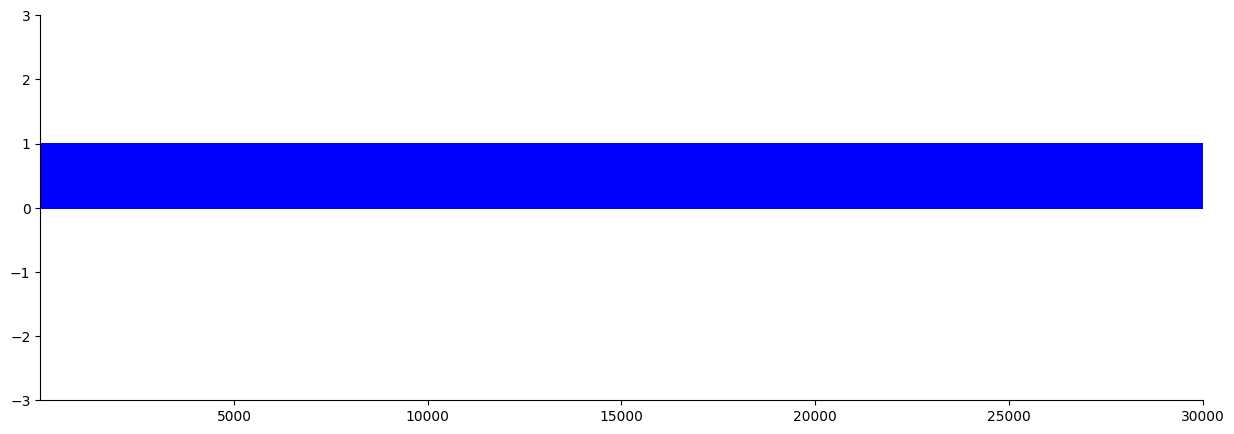

In [66]:
plt.plot(X_test,y_pred,'r')
plt.plot(X,y_true,'b')
plt.axis([1,30000,-3,3])

In [67]:
# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred) * 100
logistic_model.score(x, y)
confusion_mat = confusion_matrix(y_test, y_pred)

recall_logistic = recall_score(y_test, y_pred,average = 'weighted') * 100
precision_logistic = precision_score(y_test, y_pred,average = 'weighted',zero_division = 0) * 100
f1_logistic = f1_score(y_test, y_pred,average = 'weighted') * 100
balanced_logistic = balanced_accuracy_score(y_test,y_pred) * 100

print('Accuracy:',accuracy_logistic,'%')
print('Recall:',recall_logistic,'%')
print('Precision:',precision_logistic,'%')
print('F1:',f1_logistic,'%')
print('Balanced Accuracy:',balanced_logistic,'%')
print("Confusion Matrix:")


print(confusion_mat)


Accuracy: 48.463047743623285 %
Recall: 48.463047743623285 %
Precision: 48.399442213284814 %
F1: 47.60699282666053 %
Balanced Accuracy: 48.50484383715399 %
Confusion Matrix:
[[467 295]
 [493 274]]


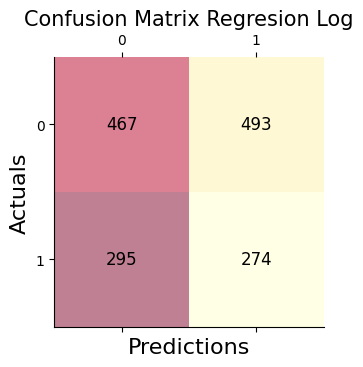

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(confusion_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mat.shape[0]):
    for n in range(confusion_mat.shape[1]):
        px.text(x=m,y=n,s=confusion_mat[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Regresion Log', fontsize=15)
plt.show()

# 4.3 Naive Bayes

In [69]:
X_train.shape, X_test.shape

((6117, 13), (1529, 13))

In [70]:
# instantiate the model
gnb = GaussianNB()
#gnb = CategoricalNB()
pgmpy


# fit the model
gnb.fit(X_train2, y_train2)

GaussianNB()

In [71]:
y_pred2 = gnb.predict(X_test2)

In [72]:
accuracy_naive = (accuracy_score(y_test2, y_pred2))*100

recall_naive = recall_score(y_test2, y_pred2,average = 'weighted') * 100
precision_naive = precision_score(y_test2, y_pred2,average = 'weighted',zero_division = 0) * 100
f1_naive = f1_score(y_test2, y_pred2,average = 'weighted') * 100
balanced_naive = balanced_accuracy_score(y_test2, y_pred2) * 100
print('Accuracy:',accuracy_naive,'%')
print('Recall:',recall_naive,'%')
print('Precision:',precision_naive,'%')
print('F1:',f1_naive,'%')
print('Balanced Accuracy:',balanced_naive,'%')

Accuracy: 51.929365598430344 %
Recall: 51.929365598430344 %
Precision: 51.95864051050045 %
F1: 51.57118017705579 %
Balanced Accuracy: 51.901261690398215 %


In [73]:
y_pred_train = gnb.predict(X_train2)

In [74]:
conf_mat = confusion_matrix(y_test2, y_pred2)

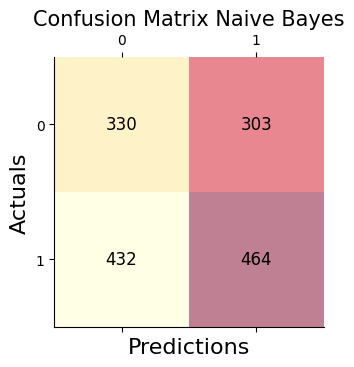

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(conf_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(conf_mat.shape[0]):
    for n in range(conf_mat.shape[1]):
        px.text(x=m,y=n,s=conf_mat[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Naive Bayes', fontsize=15)
plt.show()

## Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

X_train3 =  x[:-test_size].copy()
X_test3 = x[-test_size:].copy()
y_train3 = y[:-test_size].copy()
y_test3 = y[-test_size:].copy()

In [77]:
# Create a Random forest Classifier
clf = RandomForestClassifier(n_estimators = 1000,max_depth= None,
                             max_features= None,min_samples_split=2,
                            oob_score=True)
 
# Train the model using the training sets
clf.fit(X_train3, y_train3)

RandomForestClassifier(max_features=None, n_estimators=1000, oob_score=True)

In [78]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test3)
accuracy_forest = accuracy_score(y_test3, y_pred) * 100
clf.score(x, y)
confusion_mat = confusion_matrix(y_test3, y_pred)

recall_forest = recall_score(y_test3, y_pred,average = 'weighted') * 100
precision_forest = precision_score(y_test3, y_pred,average = 'weighted',zero_division = 0) * 100
f1_forest = f1_score(y_test3, y_pred,average = 'weighted') * 100
balanced_forest = balanced_accuracy_score(y_test3,y_pred) * 100

print('Accuracy:',accuracy_forest,'%')
print('Recall:',recall_forest,'%')
print('Precision:',precision_forest,'%')
print('F1:',f1_forest,'%')
print('Balanced Accuracy:',balanced_forest,'%')
print("Confusion Matrix:")


print(confusion_mat)


Accuracy: 48.986265533028124 %
Recall: 48.986265533028124 %
Precision: 48.96592446093882 %
F1: 48.895447236870574 %
Balanced Accuracy: 48.97245976586695 %
Confusion Matrix:
[[341 421]
 [359 408]]


# 4.5 Multilayer Perceptron

In [79]:
#import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense
import numpy as np

In [80]:
X_train4 = X_train.copy()
y_train4 = y_train.copy()
X_test4 = X_test.copy()
y_test4 = y_test.copy()
Y_train_dum = pd.get_dummies(y_train4,prefix='y')
Y_test_dum = pd.get_dummies(y_test4,prefix='y')

In [81]:
n_inputs = len(list(X_train4.columns))
n_inputs

13

In [82]:
# Neural network structure
model = Sequential()
model.add(Dense(10, activation='sigmoid', input_shape=(n_inputs,)))
#model.add(Dense(10, activation='softplus'))
model.add(Dense(2, activation='softmax'))
# Optimizer configuration
model.compile(loss='binary_crossentropy',
#model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
# Neural network training
model_history=model.fit(X_train4, Y_train_dum,epochs=50, batch_size=1, verbose=1)
#%% View the training performance
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.xlabel('Epochs'),plt.ylabel('Loss function')
plt.subplot(122)
plt.plot(model_history.history['accuracy'])
plt.xlabel('Epochs'),plt.ylabel('Accuracy function')
#%% Neural network weights
model.layers[0].get_weights()
# model.get_config() #model configuration
#%% View the model
from keras.utils import plot_model
plot_model(model)
# plot_model(model, to_file='../figures/P9_fig/model.png', show_shapes=True)

Epoch 1/50
6117/6117 [==============================] - 10s 2ms/step - loss: 0.6940 - accuracy: 0.5025
Epoch 2/50
6117/6117 [==============================] - 9s 1ms/step - loss: 0.6940 - accuracy: 0.5020
Epoch 3/50
6117/6117 [==============================] - 8s 1ms/step - loss: 0.6937 - accuracy: 0.4957
Epoch 4/50
6117/6117 [==============================] - 9s 1ms/step - loss: 0.6932 - accuracy: 0.5159
Epoch 5/50
6117/6117 [==============================] - 9s 2ms/step - loss: 0.6926 - accuracy: 0.5202
Epoch 6/50
6117/6117 [==============================] - 9s 1ms/step - loss: 0.6934 - accuracy: 0.5030
Epoch 7/50
6117/6117 [==============================] - 8s 1ms/step - loss: 0.6926 - accuracy: 0.5171
Epoch 8/50
6117/6117 [==============================] - 9s 1ms/step - loss: 0.6932 - accuracy: 0.5012
Epoch 9/50
6117/6117 [==============================] - 8s 1ms/step - loss: 0.6932 - accuracy: 0.5101
Epoch 10/50
6117/6117 [==============================] - 9s 1ms/step - loss: 0.69

In [ ]:
#%% Use the model
# Latest version
Y_prob = model.predict(X_test4)
Y_pred = np.argmax(Y_prob, axis=1)

In [ ]:
X_test4

In [ ]:
#%% View the neural network prediction
indx = 0
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.reshape(X_test4[indx,:],(8,8)),cmap=plt.cm.gray_r)
plt.subplot(122)
plt.bar(np.arange(10),Y_prob[indx,:])
plt.ylim([0,1])
plt.title('Prediction: %d'%np.argmax(Y_prob[indx,:]))

In [ ]:
#%% Evaluating the model
score = model.evaluate(X_test4, Y_test_dum,verbose=1)
print(score)

In [ ]:
#%% More metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score)
Yhat_train = np.argmax(model.predict(X_train4),axis=1)
Yhat_test = np.argmax(model.predict(X_test4),axis=1)
accu_train = accuracy_score(y_train4,Yhat_train)
prec_train = precision_score(y_train4,Yhat_train,average='weighted')
reca_train = recall_score(y_train4,Yhat_train,average='weighted')
accu_test = accuracy_score(y_test4,Yhat_test)
prec_test = precision_score(y_test4,Yhat_test,average='weighted')
reca_test = recall_score(y_test4,Yhat_test,average='weighted')
print(' \t\t Accu \t Prec \t Reca\n Train \t %0.3f \t %0.3f \t %0.3f\n  Test \t %0.3f \t %0.3f \t %0.3f'%(accu_train,prec_train,reca_train,accu_test,prec_test,reca_test))

# scores

In [ ]:
results = {'Accuracy':[accuracy_martingala,accuracy_logistic,accuracy_naive,accuracy_forest],
           'Recall':[recall_martingala,recall_logistic,recall_naive,recall_forest],
           'Precision':[precision_martingala,precision_logistic,precision_naive,precision_forest],
           'F1':[f1_martingala,f1_logistic,f1_naive,f1_forest],
           'Balanced Accuracy':[balanced_martingala,balanced_logistic,balanced_naive,balanced_forest]
          }

table=pd.DataFrame(results,index= ['Martingale','Logistic Regression','Naive Bayes','Random Forest'])
table